# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

# Что было сделано в этом ноутбуке?


В ходе лабораторной работы были использованы:
* сверточные нейронные сети с различными дополнительными методами (batch norm, layer norm, параллельные сверточные сети, ранняя установка, pooling слои), указанными в задании
* предобученные эмбединги
* рекурентные слои (однонаправленные и двунаправленные)
* ансамбль деревьев (RandomForestRegressor) для признаков, извлеченных из предпоследнего слоя лучшей модели.

Для визуализации результатов в был использован wandb. После тренировки каждой модели прикреплена ссылка на визуализацию результатов.
Все результаты доступны по ссылке: https://wandb.ai/lukicheva/my-test-project?workspace=user-lukicheva

Лучший результат по метрикам MSE и MAE показала модель **AvgPool без PAD символов**.

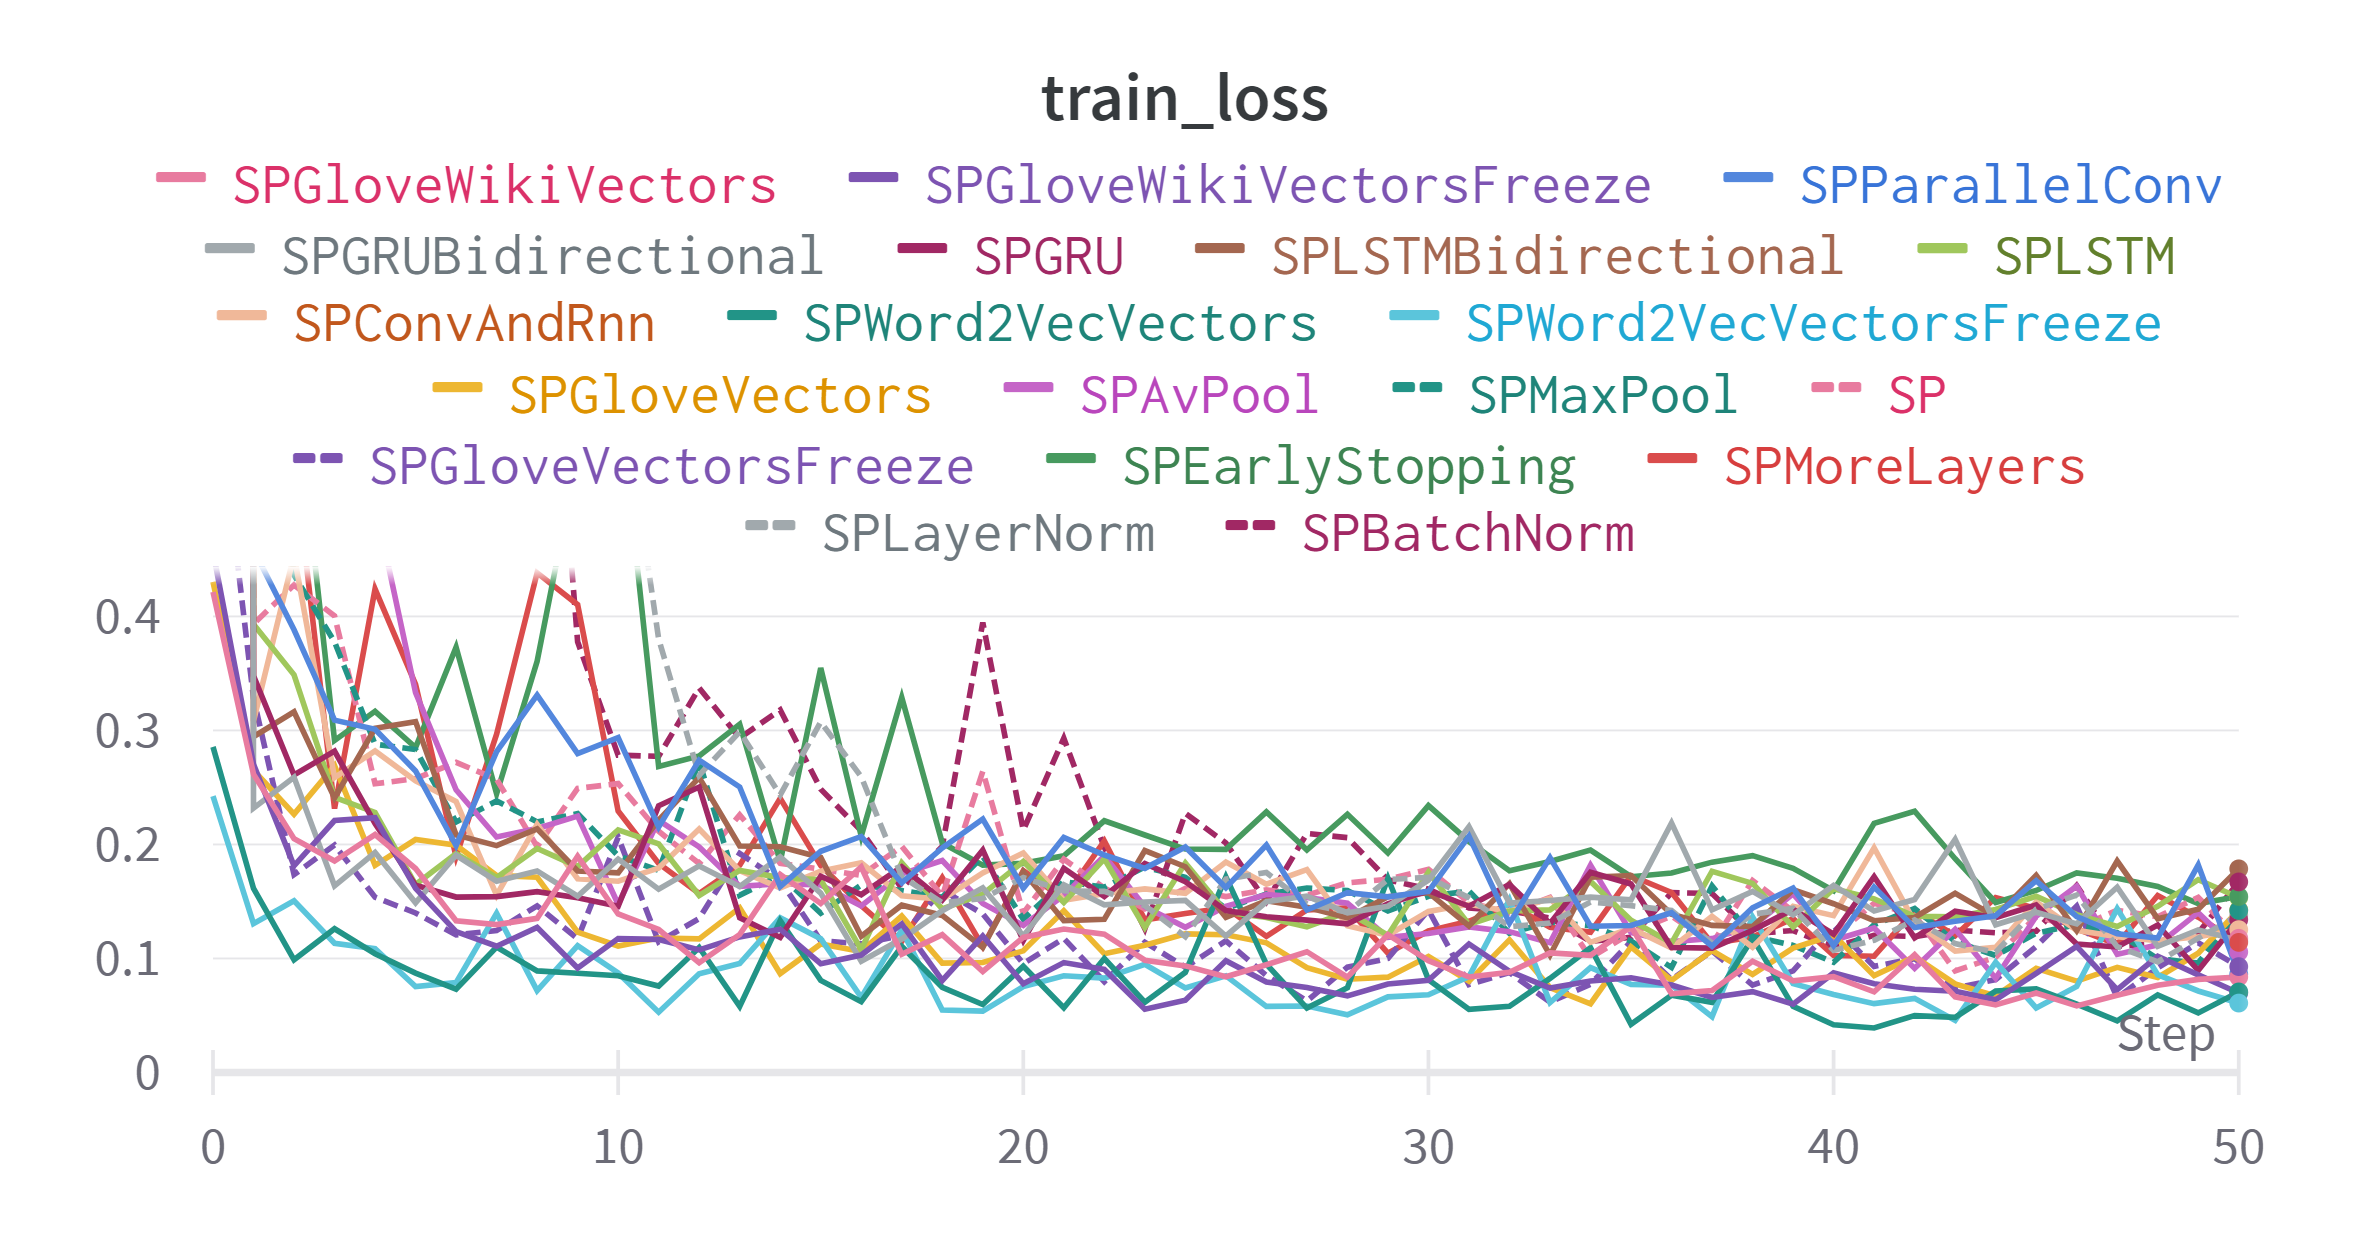

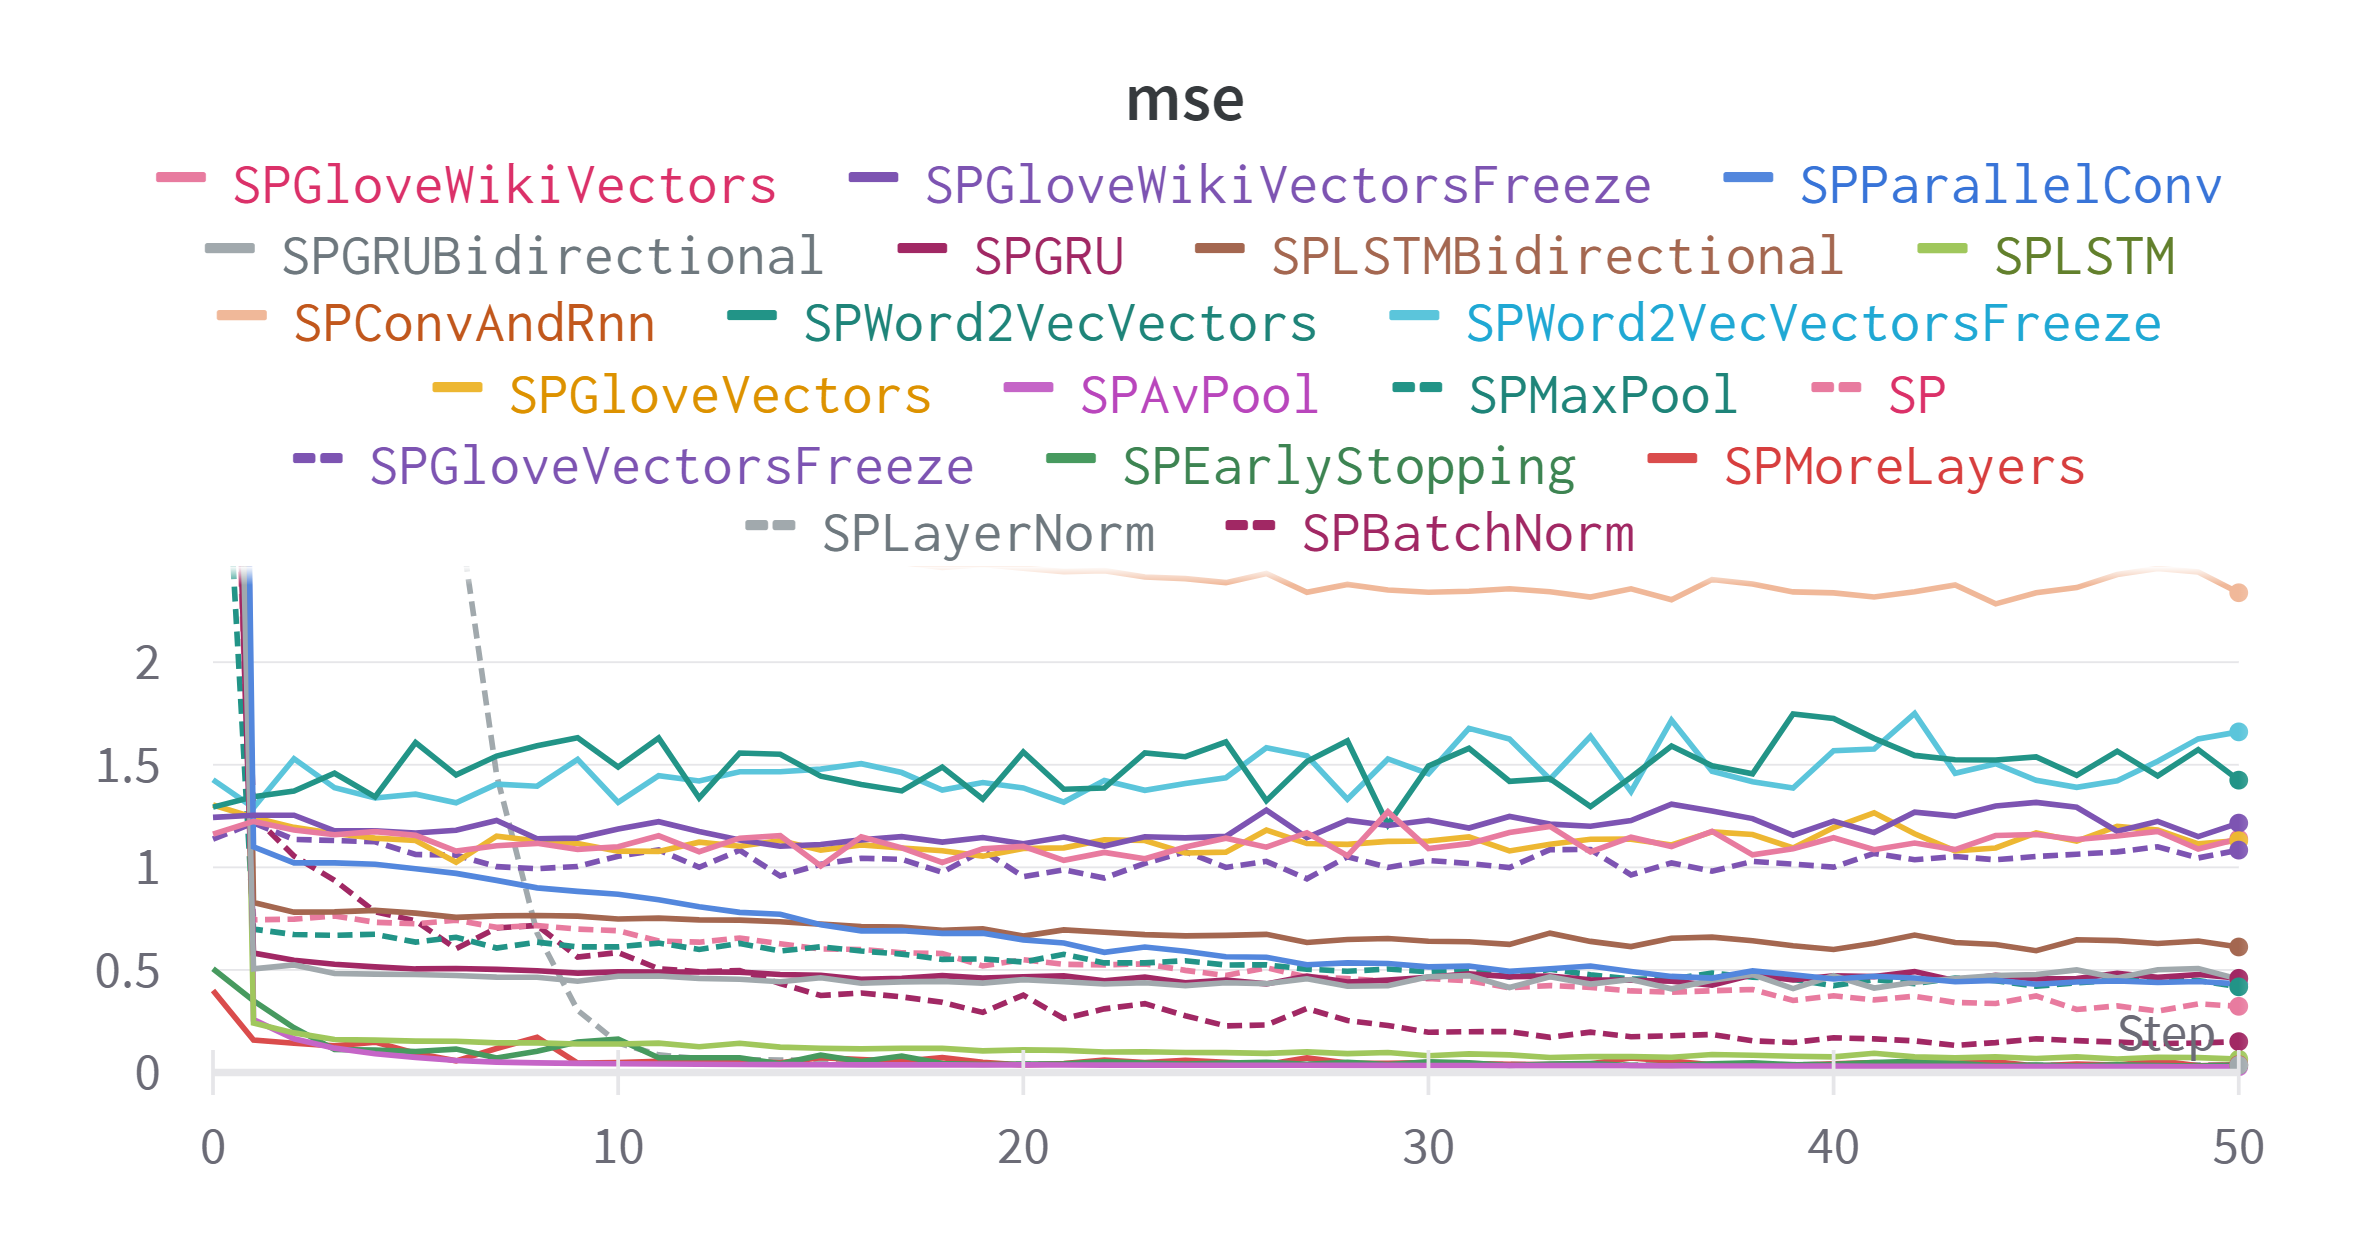

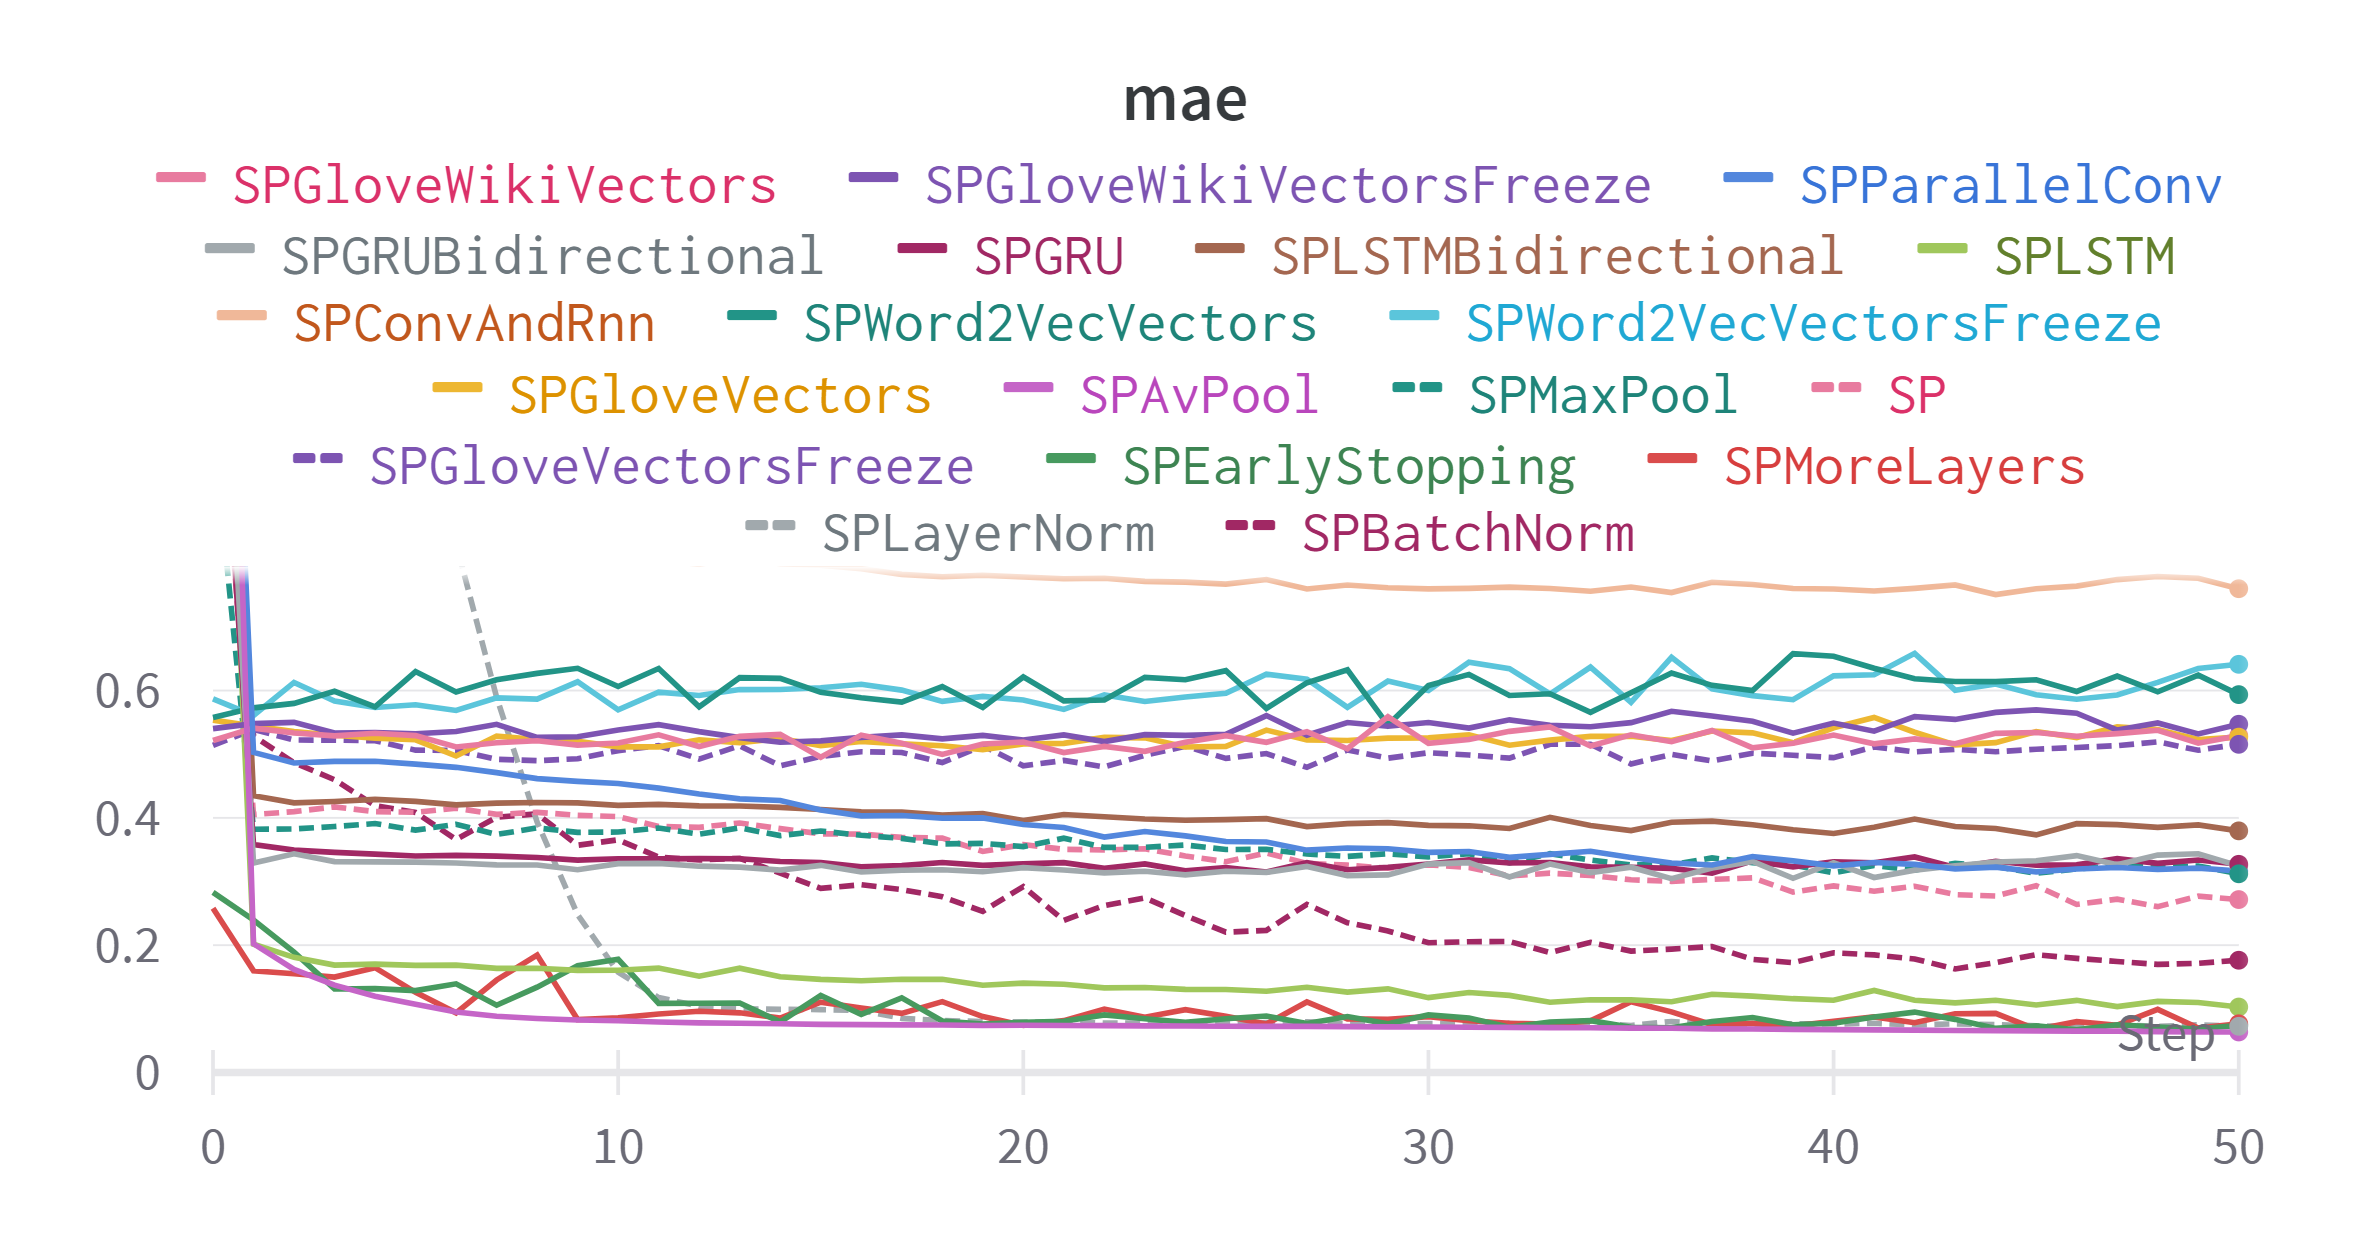

In [15]:
print_graphics('/content/drive/MyDrive/results/loss.png')
print_graphics('/content/drive/MyDrive/results/mse.png')
print_graphics('/content/drive/MyDrive/results/mae.png')

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip drive/MyDrive/Train_rev1.zip

data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

Archive:  drive/MyDrive/Train_rev1.zip
  inflating: Train_rev1.csv          


(244768, 12)

In [6]:
data.head()

Id                                              Title  \
0  12612628                        Engineering Systems Analyst   
1  12612830                            Stress Engineer Glasgow   
2  12612844                   Modelling and simulation analyst   
3  12613049  Engineering Systems Analyst / Mathematical Mod...   
4  12613647         Pioneer, Miser Engineering Systems Analyst   

                                     FullDescription  \
0  Engineering Systems Analyst Dorking Surrey Sal...   
1  Stress Engineer Glasgow Salary **** to **** We...   
2  Mathematical Modeller / Simulation Analyst / O...   
3  Engineering Systems Analyst / Mathematical Mod...   
4  Pioneer, Miser  Engineering Systems Analyst Do...   

                         LocationRaw LocationNormalized ContractType  \
0            Dorking, Surrey, Surrey            Dorking          NaN   
1        Glasgow, Scotland, Scotland            Glasgow          NaN   
2  Hampshire, South East, South East          Hampshire          NaN   
3     Surrey, South East, South East             Surrey          NaN   
4     Surrey, South East, South East             Surrey          NaN   

  ContractTime                       Company          Category  \
0    permanent  Gregory Martin International  Engineering Jobs   
1    permanent  Gregory Martin International  Engineering Jobs   
2    permanent  Gregory Martin International  Engineering Jobs   
3    permanent  Gregory Martin International  Engineering Jobs   
4    permanent  Gregory Martin International  Engineering Jobs   

                                SalaryRaw  SalaryNormalized        SourceName  
0              20000 - 30000/annum 20-30K             25000  cv-library.co.uk  
1              25000 - 35000/annum 25-35K             30000  cv-library.co.uk  
2              20000 - 40000/annum 20-40K             30000  cv-library.co.uk  
3  25000 - 30000/annum 25K-30K negotiable             27500  cv-library.co.uk  
4              20000 - 30000/annum 20-30K             25000  cv-library.co.uk

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

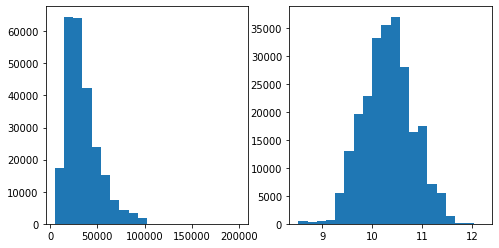

In [7]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [8]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

Id                                              Title  \
196875  71821540  Mechanical Engineer (Land Defence)  Gloucs  ****k   
97206   69258979                       Senior Investment Consultant   
89182   69146788                             CHILDCARE PRACTITIONER   

                                          FullDescription  \
196875  Mechanical Engineer Gloucs  ****k Based within...   
97206   Large asset managment firm with c pound;****bn...   
89182   Qualified childcare paractitioner working with...   

                                              LocationRaw LocationNormalized  \
196875  Cheltenham, Gloucestershire, England, Gloucest...         Cheltenham   
97206                                                  UK                 UK   
89182                                           Liverpool          Liverpool   

       ContractType ContractTime                       Company  \
196875          NaN    permanent  Jonathan Lee Recruitment Ltd   
97206           NaN    permanent                 Roland Dowell   
89182     full_time          NaN                 Kids In Bloom   

                         Category  \
196875           Engineering Jobs   
97206   Accounting & Finance Jobs   
89182               Teaching Jobs   

                                               SalaryRaw  SalaryNormalized  \
196875                               35000 - 40000/annum             37500   
97206                     50-80,000 + Bonus and Benefits             65000   
89182   6.19 per hour Negotiable depending on experience             11884   

                 SourceName  Log1pSalary  
196875     cv-library.co.uk    10.532123  
97206   ifaonlinejobs.co.uk    11.082158  
89182        Jobcentre Plus     9.383033

### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [9]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [10]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [11]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [12]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


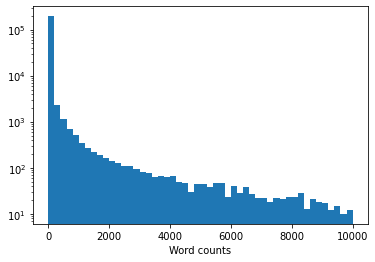

In [14]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [17]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [19]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [21]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

# Wandb

In [22]:
!pip install wandb
!wandb login

     |████████████████████████████████| 1.8 MB 33.3 MB/s 
     |████████████████████████████████| 181 kB 30.0 MB/s 
     |████████████████████████████████| 144 kB 75.8 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1d13285de70d900a0215de59bc917903e9b1fbfe0b033e0fc84abfa218a7b43b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [23]:
import wandb

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [24]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [25]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [26]:
make_batch(data_train[:3], max_len=10)

{'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631]),
 'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [27]:
import torch
import torch.nn as nn
import torch.functional as F

In [28]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [29]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [30]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cuda')
LEARNING_RATE = 1e-3

In [31]:
wandb.config = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": DEVICE
}

In [32]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [33]:
def run_model(model, name='model'):
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    wandb.init(project="my-test-project", entity="lukicheva", name=name)
    wandb.watch(model)

    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                        total=len(data_train) // BATCH_SIZE
            ):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                print('train_loss', loss.item())
                mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
                wandb.log({'train_loss': loss.item(), 'mse': mse, 'mae': mae})

In [ ]:
model = SalaryPredictor().to(DEVICE)
run_model(model, name='SP')

wandb: Currently logged in as: lukicheva (use `wandb login --relogin` to force relogin)


epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 16.254989624023438
val results:
Mean square error: 6.16821
Mean absolute error: 1.23418
train_loss 0.39336109161376953
val results:
Mean square error: 0.74435
Mean absolute error: 0.40512
train_loss 0.4275434613227844
val results:
Mean square error: 0.74757
Mean absolute error: 0.40984
train_loss 0.4004518985748291
val results:
Mean square error: 0.76309
Mean absolute error: 0.41723
train_loss 0.2532680034637451
val results:
Mean square error: 0.73230
Mean absolute error: 0.40980
train_loss 0.2576693296432495
val results:
Mean square error: 0.72463
Mean absolute error: 0.40883
train_loss 0.2719901502132416
val results:
Mean square error: 0.74237
Mean absolute error: 0.41525
train_loss 0.2571395933628082
val results:
Mean square error: 0.70760
Mean absolute error: 0.40544
train_loss 0.19807101786136627
val results:
Mean square error: 0.71613
Mean absolute error: 0.40871
train_loss 0.24917462468147278
val results:
Mean square error: 0.69909
Mean absolute error: 0.40398
train_l

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.19830910861492157
val results:
Mean square error: 0.58386
Mean absolute error: 0.36932
train_loss 0.154704749584198
val results:
Mean square error: 0.58008
Mean absolute error: 0.36825
train_loss 0.26407068967819214
val results:
Mean square error: 0.51925
Mean absolute error: 0.34721
train_loss 0.13982036709785461
val results:
Mean square error: 0.54997
Mean absolute error: 0.35820
train_loss 0.1870429962873459
val results:
Mean square error: 0.52748
Mean absolute error: 0.35049
train_loss 0.1618669182062149
val results:
Mean square error: 0.52455
Mean absolute error: 0.34963
train_loss 0.14360491931438446
val results:
Mean square error: 0.52947
Mean absolute error: 0.35149
train_loss 0.16133680939674377
val results:
Mean square error: 0.49770
Mean absolute error: 0.34013
train_loss 0.15424616634845734
val results:
Mean square error: 0.47277
Mean absolute error: 0.33104
train_loss 0.1602175235748291
val results:
Mean square error: 0.51062
Mean absolute error: 0.34506
train

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.10058766603469849
val results:
Mean square error: 0.41493
Mean absolute error: 0.30961
train_loss 0.12237659096717834
val results:
Mean square error: 0.39760
Mean absolute error: 0.30271
train_loss 0.13733622431755066
val results:
Mean square error: 0.39169
Mean absolute error: 0.30030
train_loss 0.11262824386358261
val results:
Mean square error: 0.39856
Mean absolute error: 0.30333
train_loss 0.16835764050483704
val results:
Mean square error: 0.40433
Mean absolute error: 0.30574
train_loss 0.1414385735988617
val results:
Mean square error: 0.35126
Mean absolute error: 0.28344
train_loss 0.11893082410097122
val results:
Mean square error: 0.37375
Mean absolute error: 0.29320
train_loss 0.14843551814556122
val results:
Mean square error: 0.35387
Mean absolute error: 0.28471
train_loss 0.1382753551006317
val results:
Mean square error: 0.37174
Mean absolute error: 0.29261
train_loss 0.08914946764707565
val results:
Mean square error: 0.34135
Mean absolute error: 0.27944
tr

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/2y1va70b?workspace=user-lukicheva

# **Часть 1:** развейте CNN архитектуру

В данной части происходила тренировка моделей со сверточными слоями со следующими особенностями:
* BatchNorm
* LayerNorm
* ParallelConvLayers
* Несколько сверточных слоев в одной модели
* Ранняя остановка

In [4]:
import cv2 as cv
from google.colab.patches import cv2_imshow

In [5]:
def print_graphics(path):
    img = cv.imread(path)
    img = np.float32(img)
    cv2_imshow(img)

### Using Batch Norm

In [ ]:
wandb.config = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": DEVICE
}

In [ ]:
class SalaryPredictorBatchNorm(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_batch_norm = SalaryPredictorBatchNorm().to(DEVICE)
run_model(model_batch_norm, name='SPBatchNorm')

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/1yr83fpb?workspace=user-lukicheva

### Using Layer Norm

In [ ]:
class SalaryPredictorLayerNorm(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder_conv = nn.Conv1d(hid_size, hid_size, kernel_size=2)
        self.title_encoder_layer_norm = nn.Sequential(
            nn.LayerNorm(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
        )
        self.title_encoder = nn.AdaptiveMaxPool1d(output_size=1)

        self.description_encoder_conv = nn.Conv1d(hid_size, hid_size, kernel_size=2)
        self.description_encoder_layer_norm = nn.Sequential(
            nn.LayerNorm(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
        )
        self.description_encoder = nn.AdaptiveMaxPool1d(output_size=1)
        
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.LayerNorm(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.LayerNorm(hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.LayerNorm(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder_conv(title_embeddings).permute(0, 2, 1)
        title_features =  self.title_encoder_layer_norm(title_features).permute(0, 2, 1)
        title_features = self.title_encoder(title_features).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder_conv(description_embeddings).permute(0, 2, 1)
        description_features =  self.description_encoder_layer_norm(description_features).permute(0, 2, 1)
        description_features = self.description_encoder(description_features).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_layer_norm = SalaryPredictorLayerNorm().to(DEVICE)
run_model(model_layer_norm, name='SPLayerNorm')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 92.16714477539062
val results:
Mean square error: 22.98238
Mean absolute error: 2.39381
train_loss 77.36172485351562
val results:
Mean square error: 19.37563
Mean absolute error: 2.19742
train_loss 61.570194244384766
val results:
Mean square error: 15.39998
Mean absolute error: 1.95826
train_loss 46.299774169921875
val results:
Mean square error: 11.43477
Mean absolute error: 1.68626
train_loss 31.70577049255371
val results:
Mean square error: 7.86223
Mean absolute error: 1.39655
train_loss 19.574813842773438
val results:
Mean square error: 4.94519
Mean absolute error: 1.10503
train_loss 11.098482131958008
val results:
Mean square error: 2.82053
Mean absolute error: 0.83062
train_loss 5.8250298500061035
val results:
Mean square error: 1.45118
Mean absolute error: 0.58957
train_loss 2.7896862030029297
val results:
Mean square error: 0.67963
Mean absolute error: 0.39350
train_loss 1.1187843084335327
val results:
Mean square error: 0.30285
Mean absolute error: 0.24772
train_los

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.17183423042297363
val results:
Mean square error: 0.04757
Mean absolute error: 0.08507
train_loss 0.14883646368980408
val results:
Mean square error: 0.04411
Mean absolute error: 0.08163
train_loss 0.15264125168323517
val results:
Mean square error: 0.04270
Mean absolute error: 0.08019
train_loss 0.17093896865844727
val results:
Mean square error: 0.04136
Mean absolute error: 0.07923
train_loss 0.1593409925699234
val results:
Mean square error: 0.04151
Mean absolute error: 0.07910
train_loss 0.15882839262485504
val results:
Mean square error: 0.04024
Mean absolute error: 0.07773
train_loss 0.14631372690200806
val results:
Mean square error: 0.04010
Mean absolute error: 0.07762
train_loss 0.11910119652748108
val results:
Mean square error: 0.03848
Mean absolute error: 0.07614
train_loss 0.16954255104064941
val results:
Mean square error: 0.03955
Mean absolute error: 0.07720
train_loss 0.1754201501607895
val results:
Mean square error: 0.04040
Mean absolute error: 0.07831
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.14948204159736633
val results:
Mean square error: 0.03985
Mean absolute error: 0.07755
train_loss 0.1463121473789215
val results:
Mean square error: 0.03651
Mean absolute error: 0.07377
train_loss 0.14209440350532532
val results:
Mean square error: 0.04212
Mean absolute error: 0.08016
train_loss 0.11358076333999634
val results:
Mean square error: 0.03789
Mean absolute error: 0.07523
train_loss 0.13874533772468567
val results:
Mean square error: 0.03605
Mean absolute error: 0.07329
train_loss 0.1440526694059372
val results:
Mean square error: 0.03903
Mean absolute error: 0.07677
train_loss 0.10711612552404404
val results:
Mean square error: 0.03846
Mean absolute error: 0.07613
train_loss 0.11600320786237717
val results:
Mean square error: 0.03956
Mean absolute error: 0.07733
train_loss 0.13384521007537842
val results:
Mean square error: 0.03735
Mean absolute error: 0.07462
train_loss 0.11307723820209503
val results:
Mean square error: 0.03893
Mean absolute error: 0.07646
tr

Сслыка на график: https://wandb.ai/lukicheva/my-test-project/runs/201l8dk8?workspace=user-lukicheva

### Parallel conv layer


In [33]:
class SalaryPredictorParallelConv(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2, groups=8),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2, groups=8),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2, groups=8),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2, groups=8),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [34]:
model_parallel_conv = SalaryPredictorParallelConv().to(DEVICE)
run_model(model_parallel_conv, name='SPParallelConv')

wandb: Currently logged in as: lukicheva (use `wandb login --relogin` to force relogin)


epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 49.012168884277344
val results:
Mean square error: 14.96923
Mean absolute error: 1.93061
train_loss 0.4586440920829773
val results:
Mean square error: 1.09997
Mean absolute error: 0.50288
train_loss 0.3883047103881836
val results:
Mean square error: 1.02164
Mean absolute error: 0.48626
train_loss 0.30903565883636475
val results:
Mean square error: 1.02184
Mean absolute error: 0.48881
train_loss 0.3009875416755676
val results:
Mean square error: 1.01507
Mean absolute error: 0.48885
train_loss 0.26447349786758423
val results:
Mean square error: 0.99322
Mean absolute error: 0.48438
train_loss 0.1990734040737152
val results:
Mean square error: 0.97061
Mean absolute error: 0.47938
train_loss 0.2813574969768524
val results:
Mean square error: 0.93641
Mean absolute error: 0.47101
train_loss 0.3310003876686096
val results:
Mean square error: 0.90007
Mean absolute error: 0.46172
train_loss 0.27961504459381104
val results:
Mean square error: 0.88276
Mean absolute error: 0.45741
train_

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.16627690196037292
val results:
Mean square error: 0.69170
Mean absolute error: 0.40363
train_loss 0.19696439802646637
val results:
Mean square error: 0.67842
Mean absolute error: 0.39956
train_loss 0.2223358154296875
val results:
Mean square error: 0.67944
Mean absolute error: 0.39995
train_loss 0.16160723567008972
val results:
Mean square error: 0.64639
Mean absolute error: 0.38965
train_loss 0.20606140792369843
val results:
Mean square error: 0.63110
Mean absolute error: 0.38476
train_loss 0.19074375927448273
val results:
Mean square error: 0.58565
Mean absolute error: 0.36985
train_loss 0.17905136942863464
val results:
Mean square error: 0.61144
Mean absolute error: 0.37853
train_loss 0.1977415382862091
val results:
Mean square error: 0.59069
Mean absolute error: 0.37174
train_loss 0.1620393693447113
val results:
Mean square error: 0.56428
Mean absolute error: 0.36280
train_loss 0.19940732419490814
val results:
Mean square error: 0.56196
Mean absolute error: 0.36209
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.12830016016960144
val results:
Mean square error: 0.51929
Mean absolute error: 0.34762
train_loss 0.12890538573265076
val results:
Mean square error: 0.49202
Mean absolute error: 0.33774
train_loss 0.14013229310512543
val results:
Mean square error: 0.46831
Mean absolute error: 0.32900
train_loss 0.11073307693004608
val results:
Mean square error: 0.46020
Mean absolute error: 0.32599
train_loss 0.14437063038349152
val results:
Mean square error: 0.49497
Mean absolute error: 0.33921
train_loss 0.16166874766349792
val results:
Mean square error: 0.47641
Mean absolute error: 0.33240
train_loss 0.11129718273878098
val results:
Mean square error: 0.45554
Mean absolute error: 0.32468
train_loss 0.1625804454088211
val results:
Mean square error: 0.46886
Mean absolute error: 0.32993
train_loss 0.12705755233764648
val results:
Mean square error: 0.46058
Mean absolute error: 0.32689
train_loss 0.1325916051864624
val results:
Mean square error: 0.44213
Mean absolute error: 0.31992
tr

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/1x1z5ipw?workspace=user-lukicheva

### More layers

In [ ]:
class SalaryPredictorMoreLayers(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size * 2, kernel_size=2),
            nn.BatchNorm1d(hid_size * 2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size * 2, hid_size, kernel_size=4),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size * 2, kernel_size=2),
            nn.BatchNorm1d(hid_size * 2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size * 2, hid_size, kernel_size=4),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 8),
            nn.ReLU(),
            nn.Linear(hid_size * 8, hid_size * 2),
            nn.ReLU()

        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_more_layers = SalaryPredictorMoreLayers().to(DEVICE)
run_model(model_more_layers, name='SPMoreLayers')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 1.3100965023040771
val results:
Mean square error: 0.40001
Mean absolute error: 0.25813
train_loss 0.9200774431228638
val results:
Mean square error: 0.15775
Mean absolute error: 0.15976
train_loss 0.5392125844955444
val results:
Mean square error: 0.14260
Mean absolute error: 0.15520
train_loss 0.23146003484725952
val results:
Mean square error: 0.13001
Mean absolute error: 0.14993
train_loss 0.42397716641426086
val results:
Mean square error: 0.14829
Mean absolute error: 0.16468
train_loss 0.34044647216796875
val results:
Mean square error: 0.09403
Mean absolute error: 0.12587
train_loss 0.1893606185913086
val results:
Mean square error: 0.05661
Mean absolute error: 0.09367
train_loss 0.2967323064804077
val results:
Mean square error: 0.11675
Mean absolute error: 0.14536
train_loss 0.4381941854953766
val results:
Mean square error: 0.17175
Mean absolute error: 0.18456
train_loss 0.41028475761413574
val results:
Mean square error: 0.04563
Mean absolute error: 0.08308
train_

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.11492309719324112
val results:
Mean square error: 0.05434
Mean absolute error: 0.09284
train_loss 0.17079809308052063
val results:
Mean square error: 0.07254
Mean absolute error: 0.11129
train_loss 0.1105445921421051
val results:
Mean square error: 0.04924
Mean absolute error: 0.08780
train_loss 0.17712080478668213
val results:
Mean square error: 0.03647
Mean absolute error: 0.07387
train_loss 0.15219639241695404
val results:
Mean square error: 0.04349
Mean absolute error: 0.08153
train_loss 0.20303963124752045
val results:
Mean square error: 0.06030
Mean absolute error: 0.09949
train_loss 0.1338982880115509
val results:
Mean square error: 0.04819
Mean absolute error: 0.08688
train_loss 0.1394505500793457
val results:
Mean square error: 0.05925
Mean absolute error: 0.09869
train_loss 0.14444854855537415
val results:
Mean square error: 0.04935
Mean absolute error: 0.08830
train_loss 0.11944326758384705
val results:
Mean square error: 0.03855
Mean absolute error: 0.07610
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.12308032810688019
val results:
Mean square error: 0.04258
Mean absolute error: 0.08106
train_loss 0.1726815104484558
val results:
Mean square error: 0.07079
Mean absolute error: 0.11109
train_loss 0.15787458419799805
val results:
Mean square error: 0.05533
Mean absolute error: 0.09521
train_loss 0.11316476762294769
val results:
Mean square error: 0.03725
Mean absolute error: 0.07496
train_loss 0.11874955892562866
val results:
Mean square error: 0.03890
Mean absolute error: 0.07715
train_loss 0.13501188158988953
val results:
Mean square error: 0.03550
Mean absolute error: 0.07281
train_loss 0.10274064540863037
val results:
Mean square error: 0.04187
Mean absolute error: 0.08046
train_loss 0.10199158638715744
val results:
Mean square error: 0.04784
Mean absolute error: 0.08735
train_loss 0.14195793867111206
val results:
Mean square error: 0.03992
Mean absolute error: 0.07817
train_loss 0.11998233199119568
val results:
Mean square error: 0.05218
Mean absolute error: 0.09222
t

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/1x1z5ipw?workspace=user-lukicheva

### Early Stopping

In [ ]:
!pip install pytorchtools

In [ ]:
def run_model_early_stopping(model, name='model'):
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    wandb.init(project="my-test-project", entity="lukicheva", name=name)
    wandb.watch(model)

    # early stopping
    last_loss = 100
    patience = 2
    trigger_times = 0

    for epoch in range(EPOCHS):
        valid_losses = []
        print(f"epoch: {epoch}")
        for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                        total=len(data_train) // BATCH_SIZE
            ):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                model.eval()
                with torch.no_grad():
                    for batch in iterate_minibatches(data_val, batch_size=BATCH_SIZE, shuffle=False, device=DEVICE):
                        batch_pred = model(batch)
                        loss = criterion(batch_pred, batch[TARGET_COLUMN])
                        # record validation loss
                        valid_losses.append(loss.item())
                print('train_loss', loss.item())
                mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
                wandb.log({'train_loss': loss.item(), 'mse': mse, 'mae': mae})
        
        current_loss = np.average(valid_losses)
        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                return

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = current_loss

In [ ]:
early_stop_model = SalaryPredictorMoreLayers().to(DEVICE)
run_model_early_stopping(early_stop_model, name='SPEarlyStopping')

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/21cq8ru9?workspace=user-lukicheva

### Выводы

Самыми удачными в этой части лабораторной оказались модели с *LayerNorm* и с *несколькими сверточными слоями*. У них были самые низкие показатели MSE и MAE. При этом **LayerNorm** имеет плавный график, что говорит о хорошем качестве обучения.

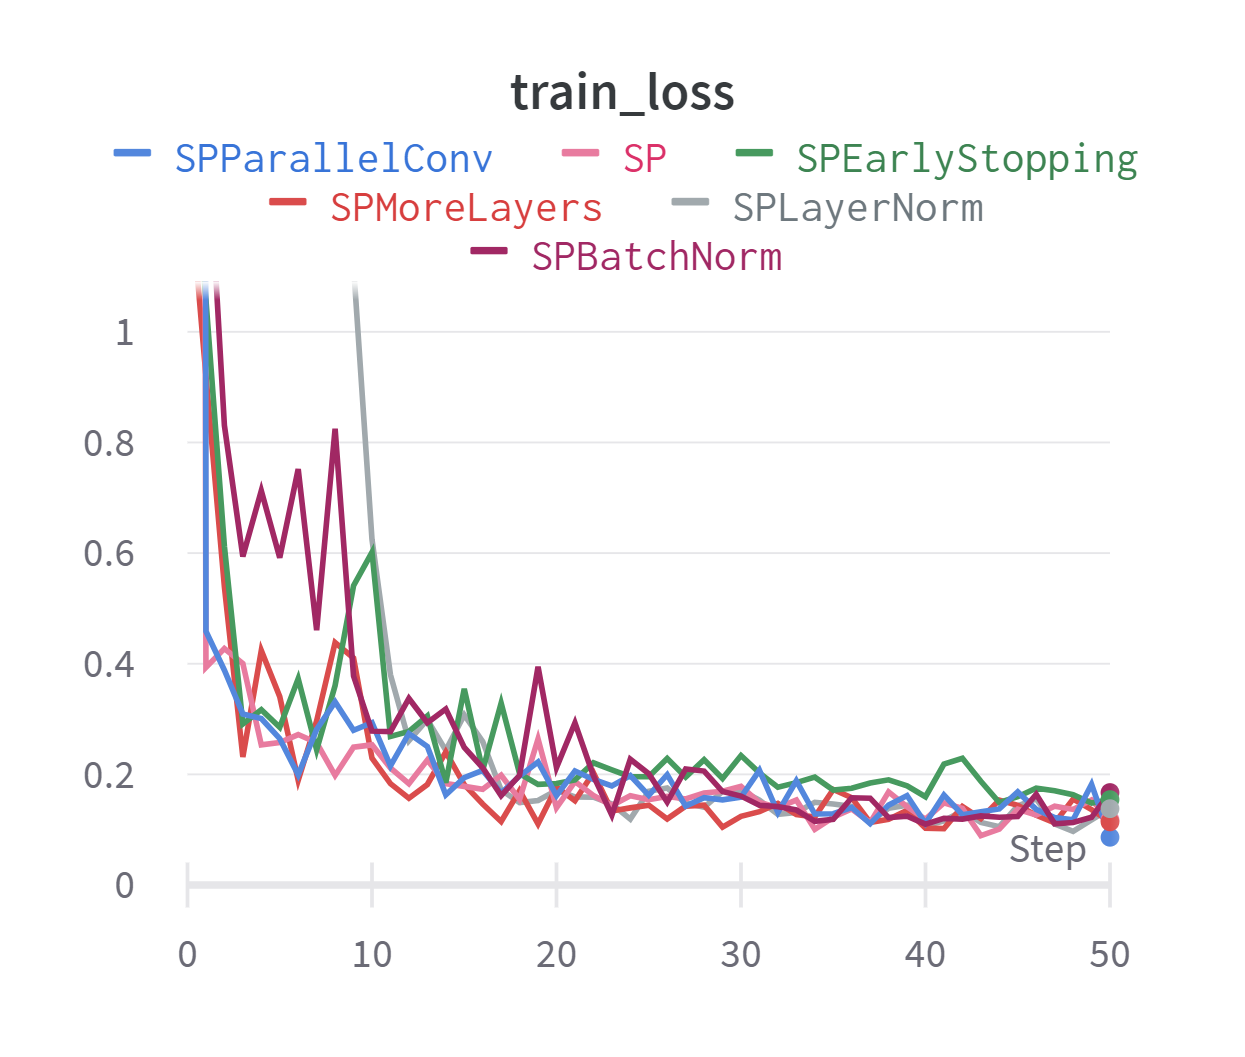

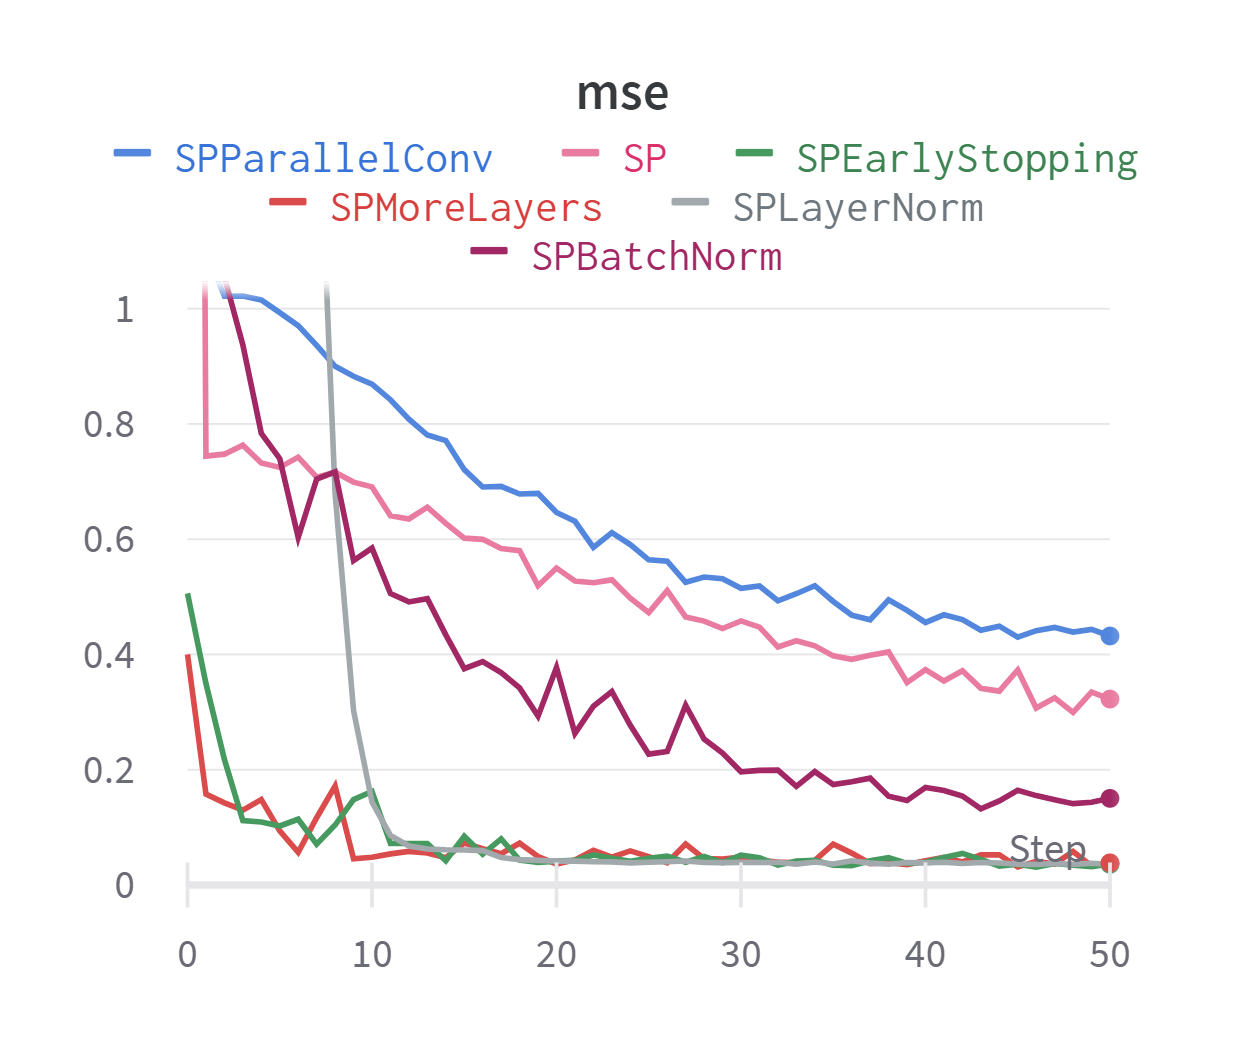

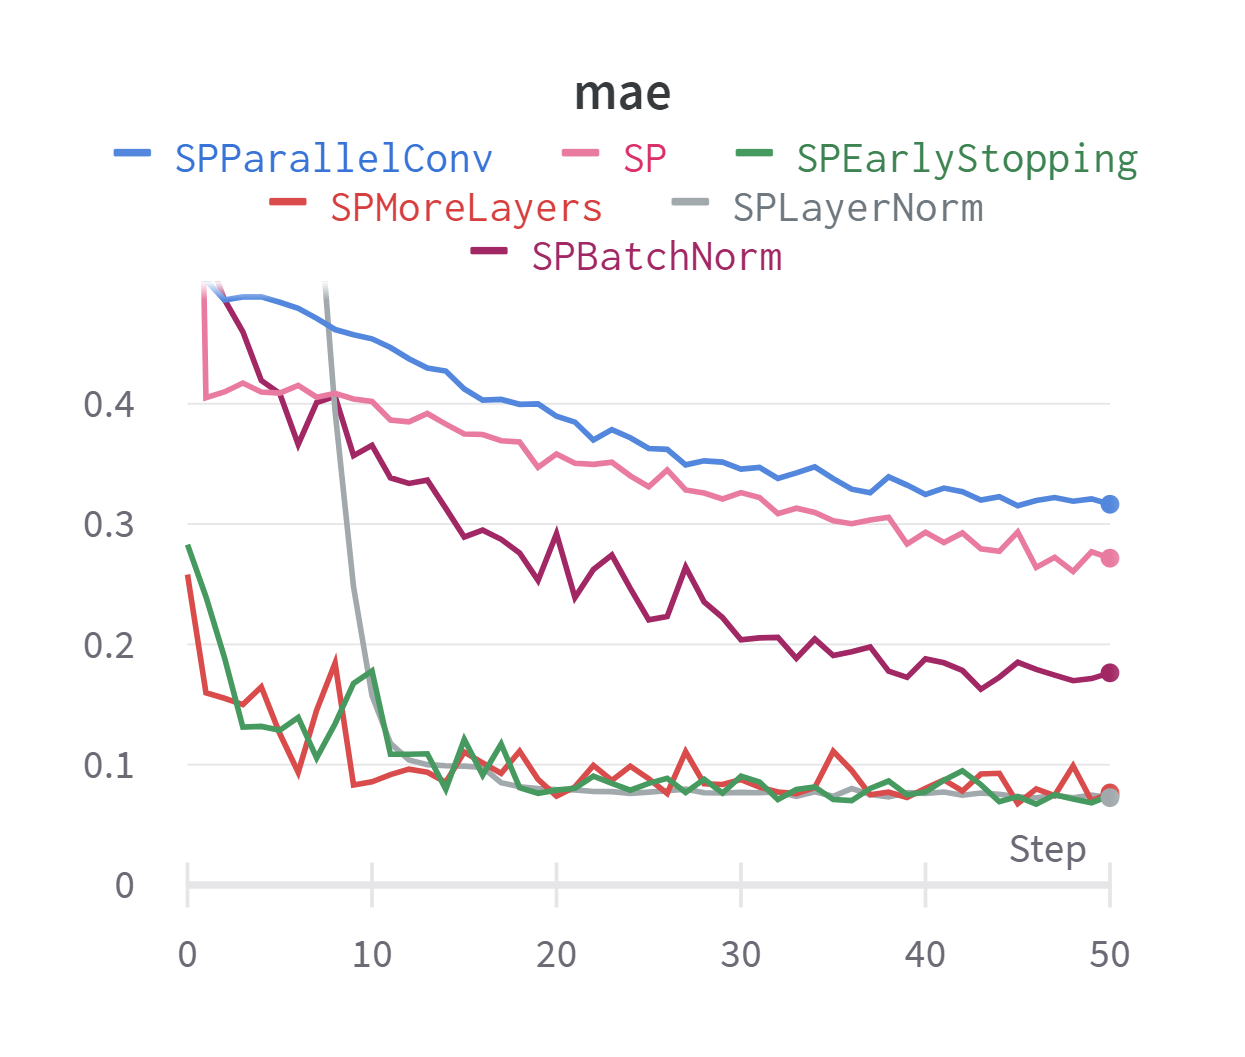

In [8]:
print_graphics('/content/drive/MyDrive/results/loss_conv.png')
print_graphics('/content/drive/MyDrive/results/mse_conv.png')
print_graphics('/content/drive/MyDrive/results/mae_conv.png')


# **Часть 2:** Pooling layers

В данной части были использованы две модели: с использованием MaxpPool и c использованием AveragePool, который не учитывал PAD-символы.

### MaxPool по временной компоненте

In [ ]:
class SalaryPredictorMaxPool(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
max_pool_model = SalaryPredictorMaxPool().to(DEVICE)

In [ ]:
run_model(max_pool_model, name='SPMaxPool')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 10.091590881347656
val results:
Mean square error: 4.23016
Mean absolute error: 1.01433
train_loss 0.7458711862564087
val results:
Mean square error: 0.69873
Mean absolute error: 0.38208
train_loss 0.43630218505859375
val results:
Mean square error: 0.67237
Mean absolute error: 0.38258
train_loss 0.3776683807373047
val results:
Mean square error: 0.66870
Mean absolute error: 0.38634
train_loss 0.2878947854042053
val results:
Mean square error: 0.67378
Mean absolute error: 0.39109
train_loss 0.2832510471343994
val results:
Mean square error: 0.63545
Mean absolute error: 0.38074
train_loss 0.21962516009807587
val results:
Mean square error: 0.65900
Mean absolute error: 0.38997
train_loss 0.23819378018379211
val results:
Mean square error: 0.60665
Mean absolute error: 0.37391
train_loss 0.2197844386100769
val results:
Mean square error: 0.63569
Mean absolute error: 0.38427
train_loss 0.2270146906375885
val results:
Mean square error: 0.61212
Mean absolute error: 0.37716
train_l

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.15954387187957764
val results:
Mean square error: 0.57715
Mean absolute error: 0.36771
train_loss 0.15368126332759857
val results:
Mean square error: 0.55162
Mean absolute error: 0.35915
train_loss 0.18952509760856628
val results:
Mean square error: 0.55350
Mean absolute error: 0.35992
train_loss 0.13446760177612305
val results:
Mean square error: 0.53875
Mean absolute error: 0.35490
train_loss 0.16740834712982178
val results:
Mean square error: 0.57621
Mean absolute error: 0.36798
train_loss 0.16253656148910522
val results:
Mean square error: 0.53428
Mean absolute error: 0.35358
train_loss 0.18018022179603577
val results:
Mean square error: 0.53448
Mean absolute error: 0.35375
train_loss 0.1711876392364502
val results:
Mean square error: 0.54468
Mean absolute error: 0.35742
train_loss 0.14376495778560638
val results:
Mean square error: 0.52393
Mean absolute error: 0.35022
train_loss 0.1564939022064209
val results:
Mean square error: 0.52485
Mean absolute error: 0.35062
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1287936270236969
val results:
Mean square error: 0.47606
Mean absolute error: 0.33367
train_loss 0.11525483429431915
val results:
Mean square error: 0.45580
Mean absolute error: 0.32614
train_loss 0.0920611098408699
val results:
Mean square error: 0.45596
Mean absolute error: 0.32627
train_loss 0.16358859837055206
val results:
Mean square error: 0.48453
Mean absolute error: 0.33703
train_loss 0.11926917731761932
val results:
Mean square error: 0.46447
Mean absolute error: 0.32965
train_loss 0.1115303486585617
val results:
Mean square error: 0.45390
Mean absolute error: 0.32570
train_loss 0.09662382304668427
val results:
Mean square error: 0.42332
Mean absolute error: 0.31390
train_loss 0.1296101212501526
val results:
Mean square error: 0.45225
Mean absolute error: 0.32524
train_loss 0.1437705159187317
val results:
Mean square error: 0.43344
Mean absolute error: 0.31801
train_loss 0.11492423713207245
val results:
Mean square error: 0.46040
Mean absolute error: 0.32846
train

In [ ]:
a = np.arange(128*8*16).reshape((128,8,16))
b = a*a
b.shape

(128, 8, 16)

Ссылка на график:https://wandb.ai/lukicheva/my-test-project/runs/2rakwrr1?workspace=user-lukicheva

### AveragePool, исключая PAD-символы

In [ ]:
class SalaryPredictorAvPool(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_conv = nn.Conv1d(hid_size, hid_size, kernel_size=1)
        self.title_encoder = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU()
        )
        self.description_conv = nn.Conv1d(hid_size, hid_size, kernel_size=1)
        self.description_encoder = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU()
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_conv = self.title_conv(title_embeddings).permute(0, 2, 1)
        
        #AveragePool without PAD symbols
        mask = batch['Title'] != PAD_IX
        
        denom = torch.sum(mask, -1, keepdim=True)
        feat = (torch.sum(title_conv * mask.unsqueeze(-1), dim=1) / denom)
        
        title_features = self.title_encoder(feat)#.squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_conv = self.description_conv(description_embeddings).permute(0, 2, 1)

        #AveragePool without PAD symbols
        mask = batch['Title'] != PAD_IX
        denom = torch.sum(mask, -1, keepdim=True)
        feat = torch.sum(title_conv * mask.unsqueeze(-1), dim=1) / denom

        description_features = self.description_encoder(feat)#.squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
av_pool_model = SalaryPredictorAvPool().to(DEVICE)
run_model(av_pool_model, name='SPAvPool')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 83.33629608154297
val results:
Mean square error: 20.46316
Mean absolute error: 2.25783
train_loss 1.0263341665267944
val results:
Mean square error: 0.25756
Mean absolute error: 0.20224
train_loss 0.7323025465011597
val results:
Mean square error: 0.16428
Mean absolute error: 0.16196
train_loss 0.4988560974597931
val results:
Mean square error: 0.11868
Mean absolute error: 0.13715
train_loss 0.49913448095321655
val results:
Mean square error: 0.09141
Mean absolute error: 0.11995
train_loss 0.333183228969574
val results:
Mean square error: 0.07375
Mean absolute error: 0.10731
train_loss 0.24799862504005432
val results:
Mean square error: 0.05852
Mean absolute error: 0.09516
train_loss 0.20651784539222717
val results:
Mean square error: 0.05079
Mean absolute error: 0.08842
train_loss 0.21403485536575317
val results:
Mean square error: 0.04699
Mean absolute error: 0.08491
train_loss 0.22490787506103516
val results:
Mean square error: 0.04430
Mean absolute error: 0.08240
train_

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.17417596280574799
val results:
Mean square error: 0.03712
Mean absolute error: 0.07475
train_loss 0.18583807349205017
val results:
Mean square error: 0.03702
Mean absolute error: 0.07452
train_loss 0.148261159658432
val results:
Mean square error: 0.03640
Mean absolute error: 0.07383
train_loss 0.1290530264377594
val results:
Mean square error: 0.03702
Mean absolute error: 0.07432
train_loss 0.15528440475463867
val results:
Mean square error: 0.03637
Mean absolute error: 0.07376
train_loss 0.1899755895137787
val results:
Mean square error: 0.03606
Mean absolute error: 0.07359
train_loss 0.1453796625137329
val results:
Mean square error: 0.03581
Mean absolute error: 0.07333
train_loss 0.12730887532234192
val results:
Mean square error: 0.03560
Mean absolute error: 0.07306
train_loss 0.14569565653800964
val results:
Mean square error: 0.03538
Mean absolute error: 0.07275
train_loss 0.15610378980636597
val results:
Mean square error: 0.03505
Mean absolute error: 0.07242
train

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1818513423204422
val results:
Mean square error: 0.03351
Mean absolute error: 0.07037
train_loss 0.12285854667425156
val results:
Mean square error: 0.03278
Mean absolute error: 0.06976
train_loss 0.11479882895946503
val results:
Mean square error: 0.03253
Mean absolute error: 0.06949
train_loss 0.1174493208527565
val results:
Mean square error: 0.03191
Mean absolute error: 0.06853
train_loss 0.1281260997056961
val results:
Mean square error: 0.03154
Mean absolute error: 0.06826
train_loss 0.15663158893585205
val results:
Mean square error: 0.03122
Mean absolute error: 0.06775
train_loss 0.1159873679280281
val results:
Mean square error: 0.03086
Mean absolute error: 0.06743
train_loss 0.12670989334583282
val results:
Mean square error: 0.03057
Mean absolute error: 0.06696
train_loss 0.09131516516208649
val results:
Mean square error: 0.03026
Mean absolute error: 0.06656
train_loss 0.12557698786258698
val results:
Mean square error: 0.02980
Mean absolute error: 0.06602
trai

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/32jrk56y?workspace=user-lukicheva

### Выводы

Loss на валидационных данных у обеих моделей во время тренировки скакал примерно в одинаковом диапозоне от 0.08 до 0.18. В то время как MSE и MAE метрики дали различные результаты, судя по которым модель с AveragePool показала себя лучше - она имеет плавный график без скачков и более низкие значения на валидационных данных, в отличае от модели с MaxPool. (MSE: 0.44 для MP и 0.28 для AP, MAE: 0.32 для MP и 0.06 для AP)

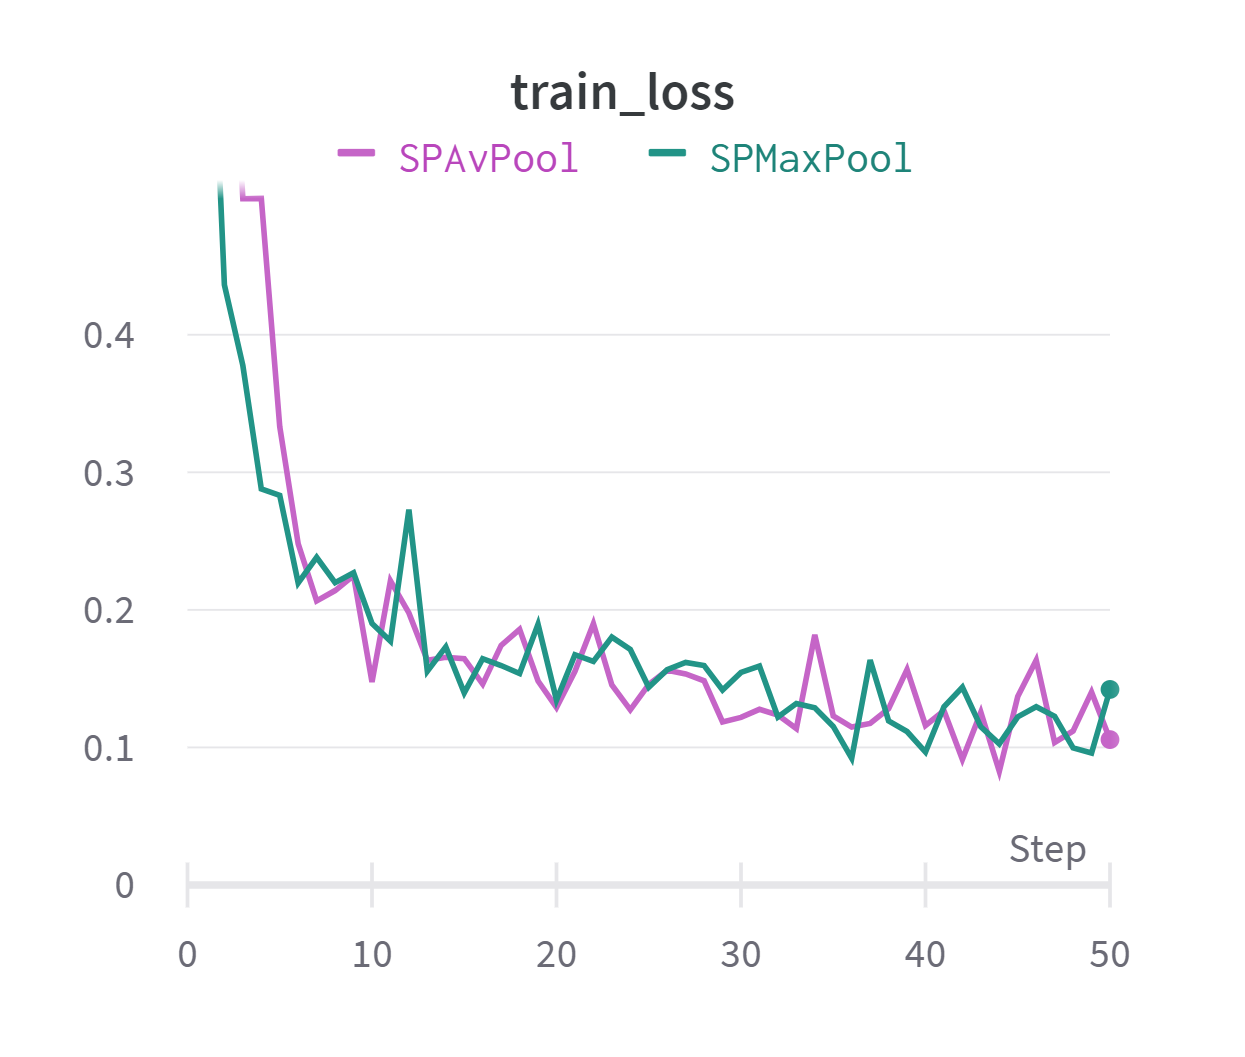

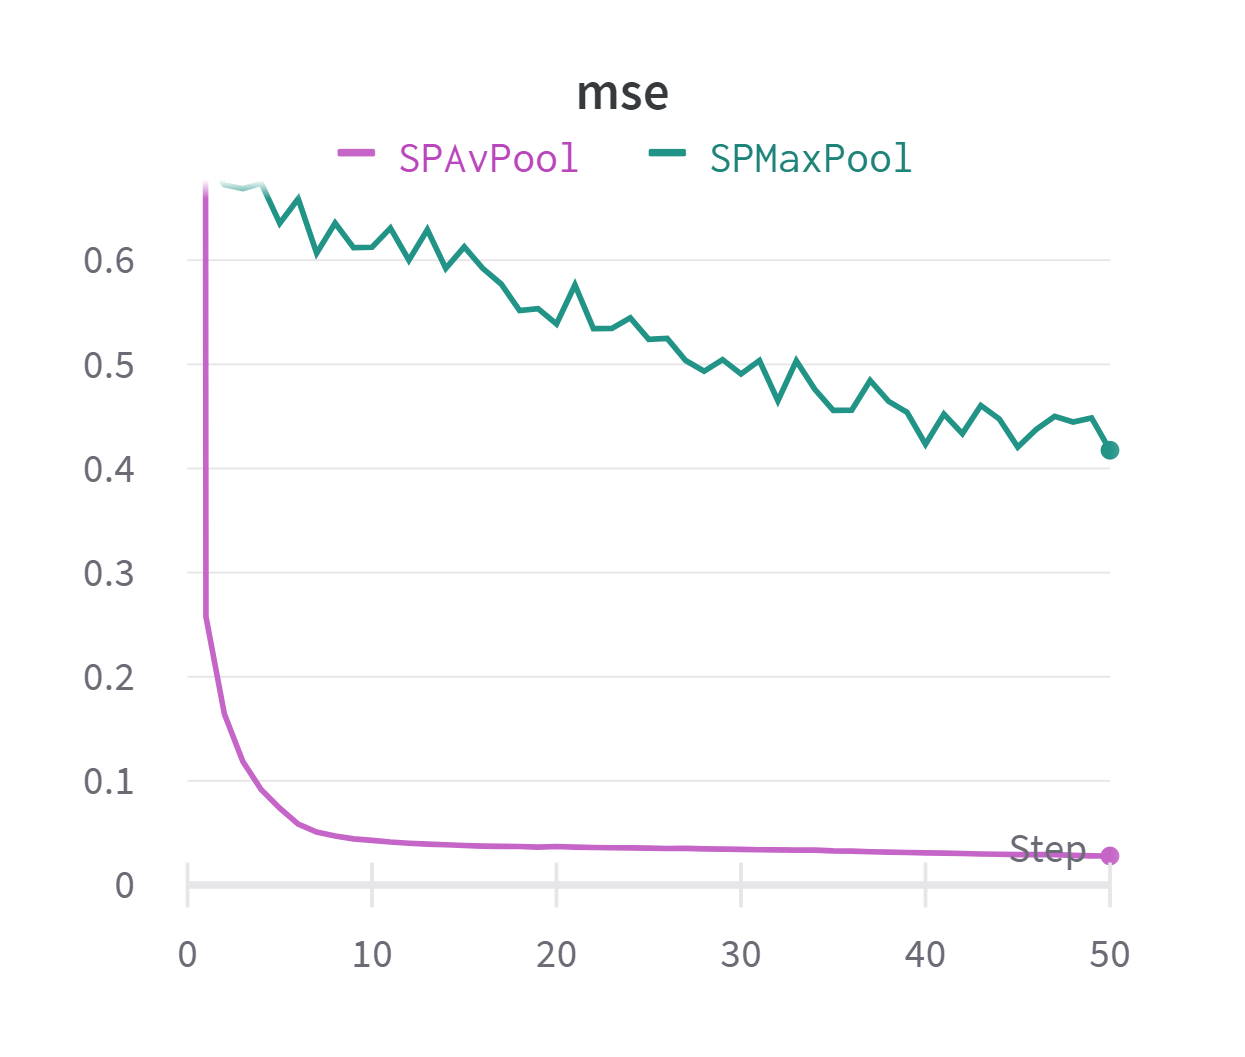

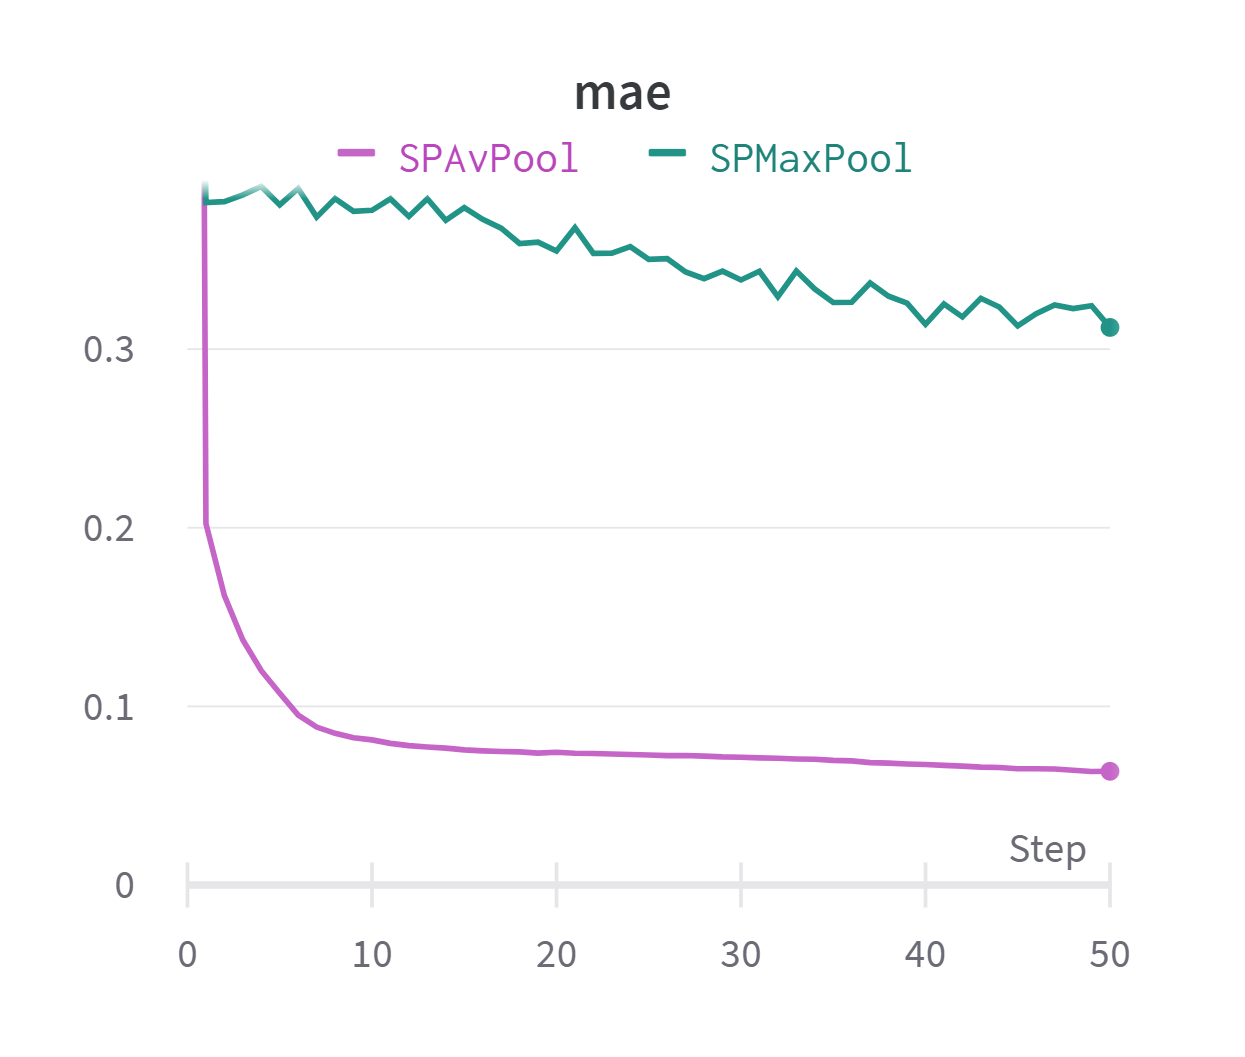

In [9]:
print_graphics('/content/drive/MyDrive/results/loss_pool.png')
print_graphics('/content/drive/MyDrive/results/mse_pool.png')
print_graphics('/content/drive/MyDrive/results/mae_pool.png')


# **Часть 3:** Pretrained embedings


В данной части использовались модели с замароженными и размороженными натренированными эмбедингами:
* glove-twitter-25
* word2vec-google-news-300
* glove-wiki-gigaword-50

In [34]:
import gensim.downloader as api

In [ ]:
# Download the "glove-twitter-25" embeddings
glove_twitter_vectors = torch.FloatTensor(api.load('glove-twitter-25').vectors).to(DEVICE)

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
word2vec_vectors = torch.FloatTensor(api.load('word2vec-google-news-300').vectors).to(DEVICE)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [35]:
glove_wiki_vectors = torch.FloatTensor(api.load('glove-wiki-gigaword-50').vectors).to(DEVICE)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [38]:
class SalaryPredictorPretrainedEmbedings(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, pretrained_weigths=[], freeze=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, pretrained_weigths.shape[1])#.from_pretrained(pretrained_weigths, freeze=freeze)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
hid_size = glove_twitter_vectors.shape[1]

In [ ]:
glove_vectors_model_freeze = SalaryPredictorPretrainedEmbedings(hid_size=hid_size, pretrained_weigths=glove_twitter_vectors, freeze=True).to(DEVICE)
run_model(glove_vectors_model_freeze, name='SPGloveVectorsFreeze')

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/325wkeg9?workspace=user-lukicheva

In [ ]:
glove_vectors_model = SalaryPredictorPretrainedEmbedings(hid_size=hid_size, pretrained_weigths=glove_twitter_vectors, freeze=False).to(DEVICE)
run_model(glove_vectors_model, name='SPGloveVectors')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.4302368760108948
val results:
Mean square error: 1.30405
Mean absolute error: 0.55358
train_loss 0.2652309536933899
val results:
Mean square error: 1.24347
Mean absolute error: 0.54413
train_loss 0.22659710049629211
val results:
Mean square error: 1.19487
Mean absolute error: 0.53571
train_loss 0.26908040046691895
val results:
Mean square error: 1.16509
Mean absolute error: 0.52981
train_loss 0.18175546824932098
val results:
Mean square error: 1.14223
Mean absolute error: 0.52499
train_loss 0.20429956912994385
val results:
Mean square error: 1.13075
Mean absolute error: 0.52269
train_loss 0.19929665327072144
val results:
Mean square error: 1.02532
Mean absolute error: 0.49720
train_loss 0.17284557223320007
val results:
Mean square error: 1.15224
Mean absolute error: 0.52846
train_loss 0.17120231688022614
val results:
Mean square error: 1.12866
Mean absolute error: 0.52318
train_loss 0.12308411300182343
val results:
Mean square error: 1.11588
Mean absolute error: 0.52036
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.13718558847904205
val results:
Mean square error: 1.09397
Mean absolute error: 0.51624
train_loss 0.09597155451774597
val results:
Mean square error: 1.08121
Mean absolute error: 0.51332
train_loss 0.09652280807495117
val results:
Mean square error: 1.05454
Mean absolute error: 0.50695
train_loss 0.10669371485710144
val results:
Mean square error: 1.09179
Mean absolute error: 0.51612
train_loss 0.14182646572589874
val results:
Mean square error: 1.09499
Mean absolute error: 0.51699
train_loss 0.10411325097084045
val results:
Mean square error: 1.13426
Mean absolute error: 0.52649
train_loss 0.1115885078907013
val results:
Mean square error: 1.13073
Mean absolute error: 0.52573
train_loss 0.12155132740736008
val results:
Mean square error: 1.07013
Mean absolute error: 0.51127
train_loss 0.12076643109321594
val results:
Mean square error: 1.07418
Mean absolute error: 0.51228
train_loss 0.1137305349111557
val results:
Mean square error: 1.18123
Mean absolute error: 0.53783
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.06030404567718506
val results:
Mean square error: 1.13711
Mean absolute error: 0.52793
train_loss 0.11019929498434067
val results:
Mean square error: 1.13754
Mean absolute error: 0.52813
train_loss 0.08069727569818497
val results:
Mean square error: 1.10924
Mean absolute error: 0.52139
train_loss 0.10693960636854172
val results:
Mean square error: 1.17288
Mean absolute error: 0.53651
train_loss 0.08601364493370056
val results:
Mean square error: 1.16004
Mean absolute error: 0.53352
train_loss 0.10908693075180054
val results:
Mean square error: 1.09478
Mean absolute error: 0.51806
train_loss 0.12062188982963562
val results:
Mean square error: 1.19414
Mean absolute error: 0.54152
train_loss 0.0849444717168808
val results:
Mean square error: 1.26549
Mean absolute error: 0.55780
train_loss 0.1014704704284668
val results:
Mean square error: 1.16366
Mean absolute error: 0.53453
train_loss 0.07765619456768036
val results:
Mean square error: 1.08022
Mean absolute error: 0.51463
tr

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/1p1nd6wv

In [ ]:
hid_size = word2vec_vectors.shape[1]

In [ ]:
word2vec_vectors_model_freeze = SalaryPredictorPretrainedEmbedings(hid_size=hid_size, pretrained_weigths=word2vec_vectors, freeze=True).to(DEVICE)
run_model(word2vec_vectors_model_freeze, name='SPWord2VecVectorsFreeze')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.24236081540584564
val results:
Mean square error: 1.42688
Mean absolute error: 0.58708
train_loss 0.13056474924087524
val results:
Mean square error: 1.29082
Mean absolute error: 0.56091
train_loss 0.1505970060825348
val results:
Mean square error: 1.52931
Mean absolute error: 0.61278
train_loss 0.11331979930400848
val results:
Mean square error: 1.38782
Mean absolute error: 0.58366
train_loss 0.10850639641284943
val results:
Mean square error: 1.33796
Mean absolute error: 0.57344
train_loss 0.07536013424396515
val results:
Mean square error: 1.35649
Mean absolute error: 0.57771
train_loss 0.07886160165071487
val results:
Mean square error: 1.31489
Mean absolute error: 0.56874
train_loss 0.13970927894115448
val results:
Mean square error: 1.40573
Mean absolute error: 0.58843
train_loss 0.07183606922626495
val results:
Mean square error: 1.39555
Mean absolute error: 0.58656
train_loss 0.11130312085151672
val results:
Mean square error: 1.52644
Mean absolute error: 0.61376
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.125041201710701
val results:
Mean square error: 1.46201
Mean absolute error: 0.60069
train_loss 0.05476564168930054
val results:
Mean square error: 1.37694
Mean absolute error: 0.58301
train_loss 0.053791336715221405
val results:
Mean square error: 1.41349
Mean absolute error: 0.59076
train_loss 0.07532569766044617
val results:
Mean square error: 1.38730
Mean absolute error: 0.58530
train_loss 0.08487671613693237
val results:
Mean square error: 1.31809
Mean absolute error: 0.57043
train_loss 0.08273028582334518
val results:
Mean square error: 1.42361
Mean absolute error: 0.59318
train_loss 0.09496013820171356
val results:
Mean square error: 1.37568
Mean absolute error: 0.58281
train_loss 0.07421945035457611
val results:
Mean square error: 1.40824
Mean absolute error: 0.58985
train_loss 0.08478070795536041
val results:
Mean square error: 1.43682
Mean absolute error: 0.59587
train_loss 0.05796167999505997
val results:
Mean square error: 1.58285
Mean absolute error: 0.62572
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.09198083728551865
val results:
Mean square error: 1.63816
Mean absolute error: 0.63680
train_loss 0.0772758275270462
val results:
Mean square error: 1.36926
Mean absolute error: 0.58161
train_loss 0.07667703926563263
val results:
Mean square error: 1.71736
Mean absolute error: 0.65226
train_loss 0.04899989813566208
val results:
Mean square error: 1.46802
Mean absolute error: 0.60261
train_loss 0.1363968849182129
val results:
Mean square error: 1.41725
Mean absolute error: 0.59203
train_loss 0.07794687151908875
val results:
Mean square error: 1.38691
Mean absolute error: 0.58558
train_loss 0.06836362183094025
val results:
Mean square error: 1.56850
Mean absolute error: 0.62309
train_loss 0.06037683039903641
val results:
Mean square error: 1.57659
Mean absolute error: 0.62472
train_loss 0.06500352919101715
val results:
Mean square error: 1.74995
Mean absolute error: 0.65848
train_loss 0.04570828005671501
val results:
Mean square error: 1.45836
Mean absolute error: 0.60062
tr

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/2owhclzo?workspace=user-lukicheva

In [ ]:
word2vec_vectors_model = SalaryPredictorPretrainedEmbedings(hid_size=hid_size, pretrained_weigths=word2vec_vectors, freeze=False).to(DEVICE)
run_model(word2vec_vectors_model, name='SPWord2VecVectors')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.28556525707244873
val results:
Mean square error: 1.29351
Mean absolute error: 0.55782
train_loss 0.16137655079364777
val results:
Mean square error: 1.34434
Mean absolute error: 0.57278
train_loss 0.09883683174848557
val results:
Mean square error: 1.37210
Mean absolute error: 0.57983
train_loss 0.12606023252010345
val results:
Mean square error: 1.45854
Mean absolute error: 0.59882
train_loss 0.10418077558279037
val results:
Mean square error: 1.34349
Mean absolute error: 0.57440
train_loss 0.08716750890016556
val results:
Mean square error: 1.60849
Mean absolute error: 0.62981
train_loss 0.07312524318695068
val results:
Mean square error: 1.45070
Mean absolute error: 0.59786
train_loss 0.110043466091156
val results:
Mean square error: 1.54246
Mean absolute error: 0.61686
train_loss 0.08908703178167343
val results:
Mean square error: 1.59213
Mean absolute error: 0.62696
train_loss 0.0870676189661026
val results:
Mean square error: 1.63227
Mean absolute error: 0.63500
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.11058174818754196
val results:
Mean square error: 1.37243
Mean absolute error: 0.58186
train_loss 0.07469144463539124
val results:
Mean square error: 1.48879
Mean absolute error: 0.60634
train_loss 0.059652186930179596
val results:
Mean square error: 1.33272
Mean absolute error: 0.57340
train_loss 0.09323209524154663
val results:
Mean square error: 1.56209
Mean absolute error: 0.62142
train_loss 0.05677821859717369
val results:
Mean square error: 1.38057
Mean absolute error: 0.58380
train_loss 0.0999184101819992
val results:
Mean square error: 1.38659
Mean absolute error: 0.58516
train_loss 0.061643343418836594
val results:
Mean square error: 1.55810
Mean absolute error: 0.62077
train_loss 0.08783591538667679
val results:
Mean square error: 1.53902
Mean absolute error: 0.61691
train_loss 0.1715201437473297
val results:
Mean square error: 1.61094
Mean absolute error: 0.63126
train_loss 0.09494955837726593
val results:
Mean square error: 1.32480
Mean absolute error: 0.57191


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.10939093679189682
val results:
Mean square error: 1.29674
Mean absolute error: 0.56580
train_loss 0.04231562465429306
val results:
Mean square error: 1.43944
Mean absolute error: 0.59656
train_loss 0.06775356829166412
val results:
Mean square error: 1.59152
Mean absolute error: 0.62762
train_loss 0.06151232123374939
val results:
Mean square error: 1.49533
Mean absolute error: 0.60819
train_loss 0.1178361177444458
val results:
Mean square error: 1.45561
Mean absolute error: 0.59994
train_loss 0.058046869933605194
val results:
Mean square error: 1.74741
Mean absolute error: 0.65799
train_loss 0.04192239046096802
val results:
Mean square error: 1.72603
Mean absolute error: 0.65381
train_loss 0.039068058133125305
val results:
Mean square error: 1.62879
Mean absolute error: 0.63500
train_loss 0.049868784844875336
val results:
Mean square error: 1.54561
Mean absolute error: 0.61859
train_loss 0.04831550270318985
val results:
Mean square error: 1.52439
Mean absolute error: 0.6141

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/28jikxl6?workspace=user-lukicheva

In [36]:
hid_size = glove_wiki_vectors.shape[1]

In [39]:
glove_wiki_vectors_model_freeze = SalaryPredictorPretrainedEmbedings(hid_size=hid_size, pretrained_weigths=glove_wiki_vectors, freeze=True).to(DEVICE)
run_model(glove_wiki_vectors_model_freeze, name='SPGloveWikiVectorsFreeze')

wandb: Currently logged in as: lukicheva (use `wandb login --relogin` to force relogin)


epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.45698773860931396
val results:
Mean square error: 1.24339
Mean absolute error: 0.54025
train_loss 0.27024921774864197
val results:
Mean square error: 1.25400
Mean absolute error: 0.54797
train_loss 0.18131452798843384
val results:
Mean square error: 1.25393
Mean absolute error: 0.54999
train_loss 0.22098353505134583
val results:
Mean square error: 1.17769
Mean absolute error: 0.53337
train_loss 0.22341522574424744
val results:
Mean square error: 1.17763
Mean absolute error: 0.53402
train_loss 0.16144075989723206
val results:
Mean square error: 1.16729
Mean absolute error: 0.53210
train_loss 0.12352901697158813
val results:
Mean square error: 1.18096
Mean absolute error: 0.53564
train_loss 0.11073455214500427
val results:
Mean square error: 1.22863
Mean absolute error: 0.54694
train_loss 0.12728114426136017
val results:
Mean square error: 1.13962
Mean absolute error: 0.52641
train_loss 0.09161030501127243
val results:
Mean square error: 1.14259
Mean absolute error: 0.52736


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.13030952215194702
val results:
Mean square error: 1.14983
Mean absolute error: 0.53027
train_loss 0.08072511851787567
val results:
Mean square error: 1.12326
Mean absolute error: 0.52419
train_loss 0.1197393462061882
val results:
Mean square error: 1.14528
Mean absolute error: 0.52955
train_loss 0.07780395448207855
val results:
Mean square error: 1.11513
Mean absolute error: 0.52245
train_loss 0.09640119969844818
val results:
Mean square error: 1.14765
Mean absolute error: 0.53024
train_loss 0.09038695693016052
val results:
Mean square error: 1.10375
Mean absolute error: 0.51991
train_loss 0.05549955368041992
val results:
Mean square error: 1.14895
Mean absolute error: 0.53074
train_loss 0.06335420906543732
val results:
Mean square error: 1.14363
Mean absolute error: 0.52955
train_loss 0.09805740416049957
val results:
Mean square error: 1.15104
Mean absolute error: 0.53137
train_loss 0.07935497164726257
val results:
Mean square error: 1.27894
Mean absolute error: 0.56070
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.08026495575904846
val results:
Mean square error: 1.20054
Mean absolute error: 0.54316
train_loss 0.08307471871376038
val results:
Mean square error: 1.22816
Mean absolute error: 0.54955
train_loss 0.0767023116350174
val results:
Mean square error: 1.30802
Mean absolute error: 0.56748
train_loss 0.06577864289283752
val results:
Mean square error: 1.27425
Mean absolute error: 0.56005
train_loss 0.07087990641593933
val results:
Mean square error: 1.23755
Mean absolute error: 0.55184
train_loss 0.059907466173172
val results:
Mean square error: 1.15637
Mean absolute error: 0.53309
train_loss 0.08733005076646805
val results:
Mean square error: 1.22520
Mean absolute error: 0.54899
train_loss 0.07786569744348526
val results:
Mean square error: 1.16943
Mean absolute error: 0.53613
train_loss 0.07305534183979034
val results:
Mean square error: 1.26919
Mean absolute error: 0.55906
train_loss 0.07125186920166016
val results:
Mean square error: 1.24962
Mean absolute error: 0.55467
tra

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/7c5p0v7k?workspace=user-lukicheva

In [40]:
glove_wiki_vectors_model = SalaryPredictorPretrainedEmbedings(hid_size=hid_size, pretrained_weigths=glove_wiki_vectors, freeze=False).to(DEVICE)
run_model(glove_wiki_vectors_model, name='SPGloveWikiVectors')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.4213961660861969
val results:
Mean square error: 1.16161
Mean absolute error: 0.52147
train_loss 0.26160210371017456
val results:
Mean square error: 1.22380
Mean absolute error: 0.54093
train_loss 0.20507711172103882
val results:
Mean square error: 1.18201
Mean absolute error: 0.53322
train_loss 0.18549463152885437
val results:
Mean square error: 1.15920
Mean absolute error: 0.52882
train_loss 0.20870907604694366
val results:
Mean square error: 1.17395
Mean absolute error: 0.53298
train_loss 0.17887592315673828
val results:
Mean square error: 1.15605
Mean absolute error: 0.52925
train_loss 0.13304322957992554
val results:
Mean square error: 1.07920
Mean absolute error: 0.51130
train_loss 0.1296738237142563
val results:
Mean square error: 1.10536
Mean absolute error: 0.51800
train_loss 0.13518080115318298
val results:
Mean square error: 1.11707
Mean absolute error: 0.52121
train_loss 0.1896159052848816
val results:
Mean square error: 1.08766
Mean absolute error: 0.51424
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.10365884006023407
val results:
Mean square error: 1.09500
Mean absolute error: 0.51711
train_loss 0.12084232270717621
val results:
Mean square error: 1.02362
Mean absolute error: 0.49969
train_loss 0.08859669417142868
val results:
Mean square error: 1.08991
Mean absolute error: 0.51607
train_loss 0.11844535171985626
val results:
Mean square error: 1.10236
Mean absolute error: 0.51916
train_loss 0.1258099377155304
val results:
Mean square error: 1.03406
Mean absolute error: 0.50258
train_loss 0.12126876413822174
val results:
Mean square error: 1.07286
Mean absolute error: 0.51217
train_loss 0.09849227964878082
val results:
Mean square error: 1.04168
Mean absolute error: 0.50458
train_loss 0.0934981182217598
val results:
Mean square error: 1.09898
Mean absolute error: 0.51868
train_loss 0.08393580466508865
val results:
Mean square error: 1.14224
Mean absolute error: 0.52910
train_loss 0.09450236707925797
val results:
Mean square error: 1.09836
Mean absolute error: 0.51866
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.10274733603000641
val results:
Mean square error: 1.07521
Mean absolute error: 0.51291
train_loss 0.12801475822925568
val results:
Mean square error: 1.14714
Mean absolute error: 0.53043
train_loss 0.06902897357940674
val results:
Mean square error: 1.10115
Mean absolute error: 0.51964
train_loss 0.07180452346801758
val results:
Mean square error: 1.17522
Mean absolute error: 0.53722
train_loss 0.09752697497606277
val results:
Mean square error: 1.06078
Mean absolute error: 0.51001
train_loss 0.08045042306184769
val results:
Mean square error: 1.09025
Mean absolute error: 0.51719
train_loss 0.08411533385515213
val results:
Mean square error: 1.14410
Mean absolute error: 0.53007
train_loss 0.07074211537837982
val results:
Mean square error: 1.08586
Mean absolute error: 0.51624
train_loss 0.10326598584651947
val results:
Mean square error: 1.11831
Mean absolute error: 0.52408
train_loss 0.06635911762714386
val results:
Mean square error: 1.08653
Mean absolute error: 0.51648


Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/3cr5ubxr?workspace=user-lukicheva

### Выводы

Модели с использованием натренированных эмбедингов показали плохие результаты. Loss, MSE и MAE на валидационных данных очень скакали не зависимо от использования freeze. Возможно, данные не очень подходят для работы с этими эмбедингами, но это не точно)))

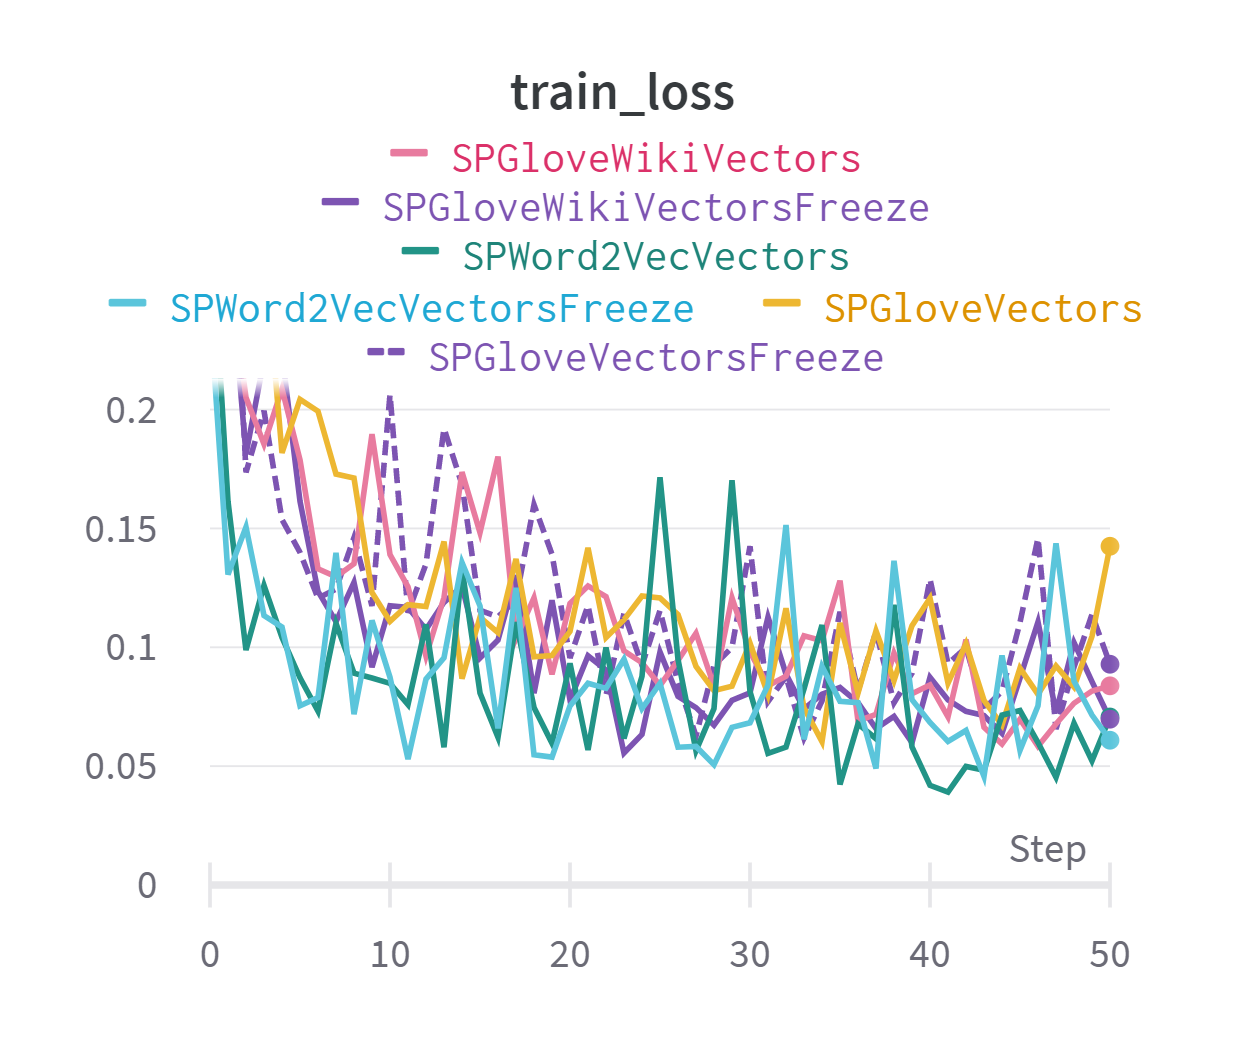

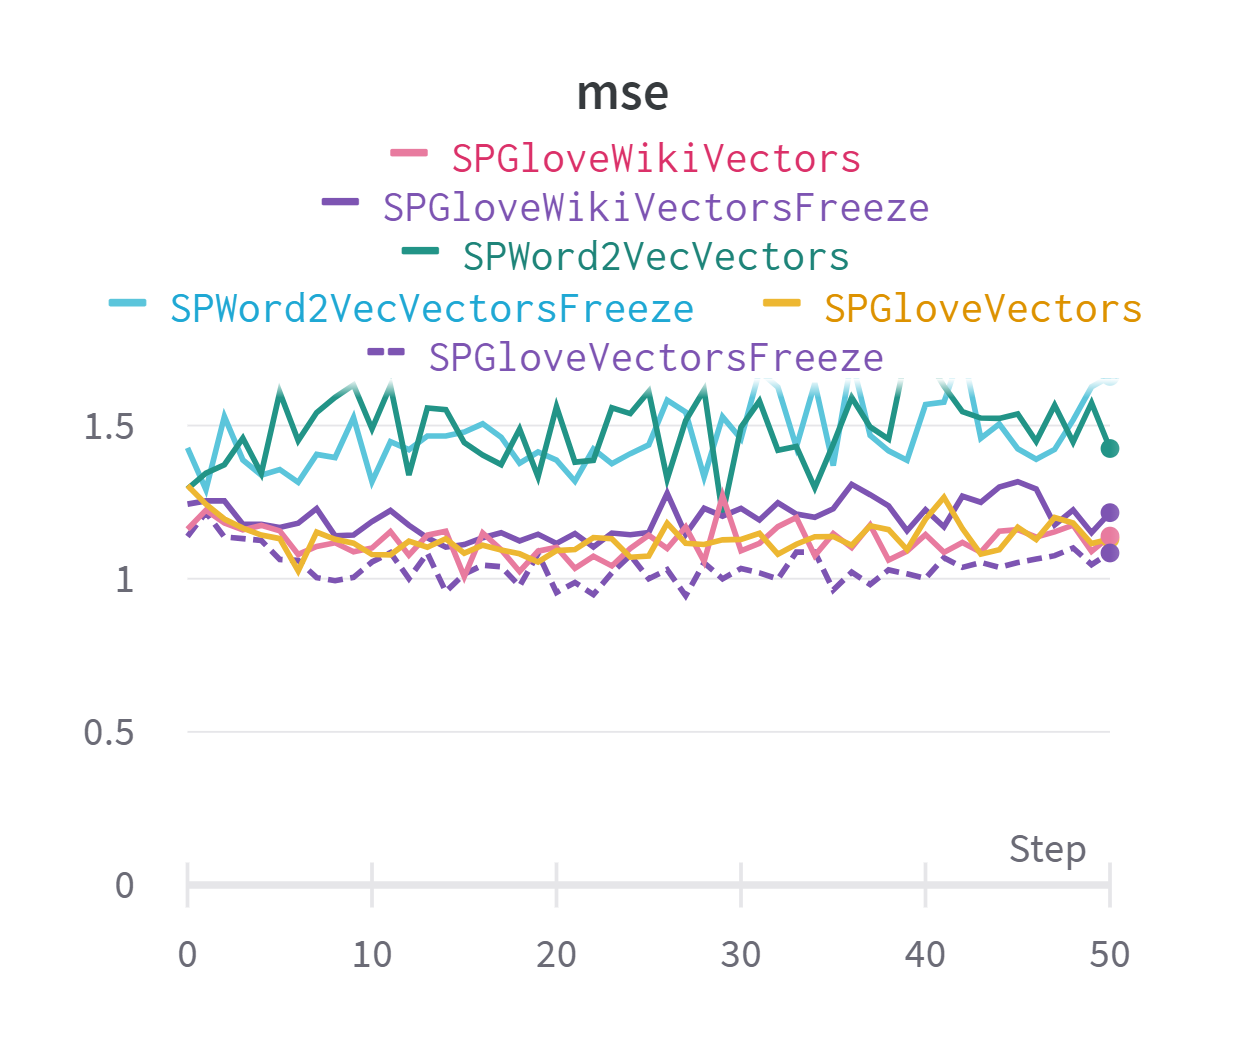

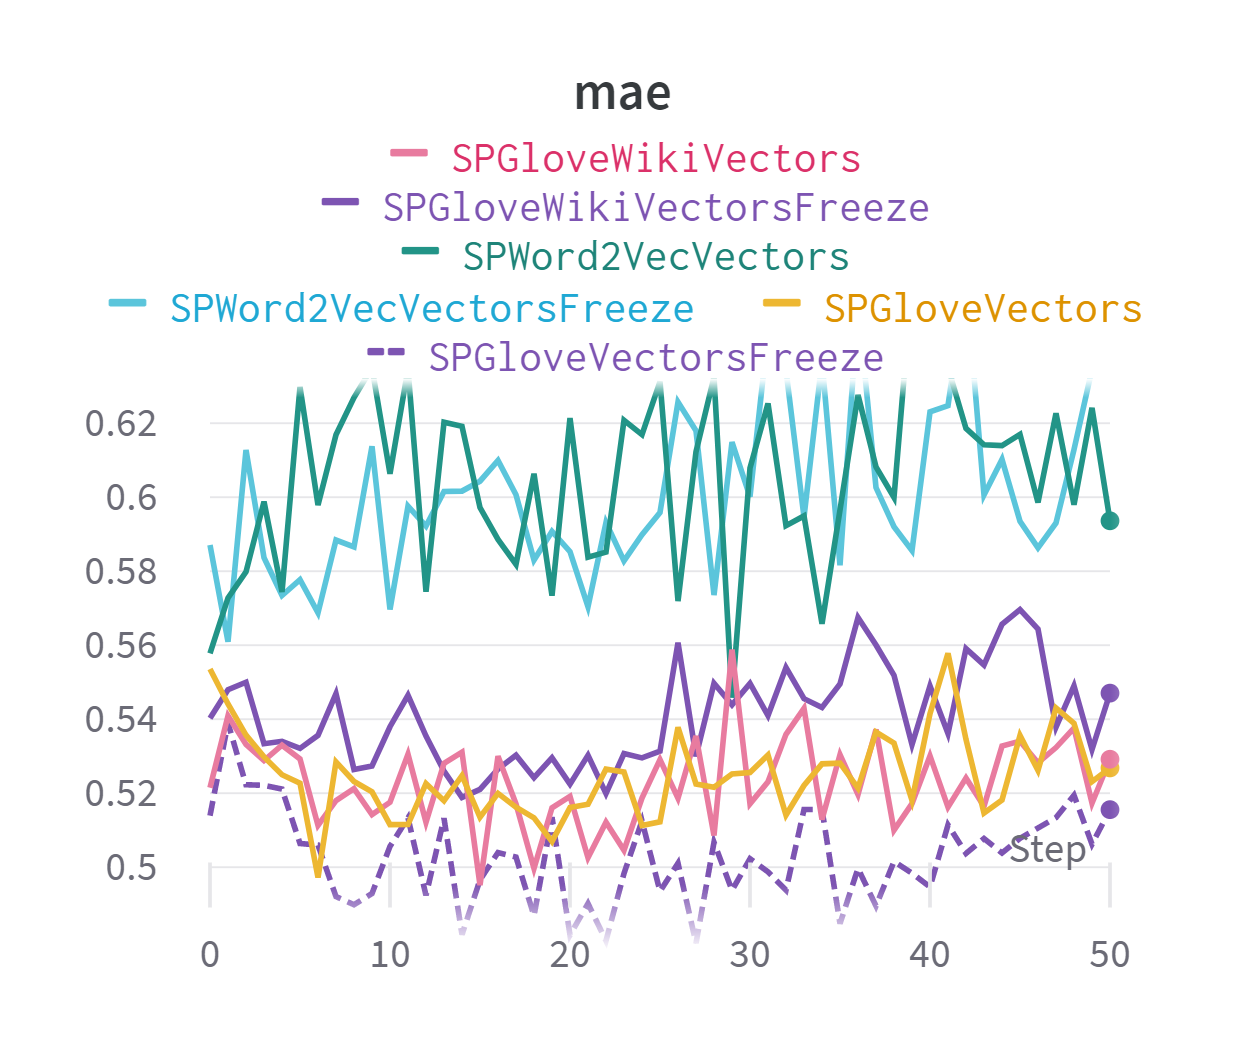

In [13]:
print_graphics('/content/drive/MyDrive/results/loss_emb.png')
print_graphics('/content/drive/MyDrive/results/mse_emb.png')
print_graphics('/content/drive/MyDrive/results/mae_emb.png')

# **Часть 4:** рекурентные нейронные сети

В этой части лабораторной в моделях использовались рекурентные слои LSTM и GRU, а также их комбинация сл сверточным слоем.

### LSTM


In [32]:
class SalaryPredictorLSTM(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, num_layers=2, bidirectional=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder_LSTM = nn.LSTM(hid_size, hid_size, num_layers, bidirectional=bidirectional)
        self.title_encoder = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_LSTM = nn.LSTM(hid_size, hid_size, num_layers, bidirectional=bidirectional)
        self.description_encoder = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        if bidirectional:
            num_ = 6
        else:
            num_ = 4
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * num_, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title'])
        title_features, (hn, cn) = self.title_encoder_LSTM(title_embeddings)
        title_features = self.title_encoder(title_features.permute(0, 2, 1)).squeeze()

        description_embeddings = self.embedder(batch['FullDescription'])
        description_features, (hn, cn) = self.description_encoder_LSTM(description_embeddings)
        description_features = self.description_encoder(description_features.permute(0, 2, 1)).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])
        
        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
         
        return self.final_predictor(features).squeeze()

In [33]:
LSTM_model = SalaryPredictorLSTM().to(DEVICE)
run_model(LSTM_model, name='SPLSTM')

wandb: Currently logged in as: lukicheva (use `wandb login --relogin` to force relogin)


epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 39.92112731933594
val results:
Mean square error: 10.59539
Mean absolute error: 1.62256
train_loss 0.3931683897972107
val results:
Mean square error: 0.24126
Mean absolute error: 0.20148
train_loss 0.3487537205219269
val results:
Mean square error: 0.19311
Mean absolute error: 0.18089
train_loss 0.24122904241085052
val results:
Mean square error: 0.16086
Mean absolute error: 0.16877
train_loss 0.22808904945850372
val results:
Mean square error: 0.15763
Mean absolute error: 0.17016
train_loss 0.16485287249088287
val results:
Mean square error: 0.15313
Mean absolute error: 0.16821
train_loss 0.19197654724121094
val results:
Mean square error: 0.15236
Mean absolute error: 0.16859
train_loss 0.17108303308486938
val results:
Mean square error: 0.14454
Mean absolute error: 0.16358
train_loss 0.19650332629680634
val results:
Mean square error: 0.14428
Mean absolute error: 0.16376
train_loss 0.18051758408546448
val results:
Mean square error: 0.13899
Mean absolute error: 0.16034
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.18378445506095886
val results:
Mean square error: 0.11797
Mean absolute error: 0.14640
train_loss 0.1434575915336609
val results:
Mean square error: 0.11781
Mean absolute error: 0.14639
train_loss 0.15646108984947205
val results:
Mean square error: 0.10567
Mean absolute error: 0.13704
train_loss 0.18505066633224487
val results:
Mean square error: 0.11010
Mean absolute error: 0.14048
train_loss 0.14911043643951416
val results:
Mean square error: 0.10759
Mean absolute error: 0.13872
train_loss 0.18734878301620483
val results:
Mean square error: 0.10019
Mean absolute error: 0.13289
train_loss 0.127134770154953
val results:
Mean square error: 0.10099
Mean absolute error: 0.13356
train_loss 0.18367034196853638
val results:
Mean square error: 0.09735
Mean absolute error: 0.13055
train_loss 0.14065687358379364
val results:
Mean square error: 0.09683
Mean absolute error: 0.13031
train_loss 0.13587820529937744
val results:
Mean square error: 0.09350
Mean absolute error: 0.12769
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.16762852668762207
val results:
Mean square error: 0.07759
Mean absolute error: 0.11433
train_loss 0.13347655534744263
val results:
Mean square error: 0.07754
Mean absolute error: 0.11410
train_loss 0.11356561630964279
val results:
Mean square error: 0.07405
Mean absolute error: 0.11117
train_loss 0.17652186751365662
val results:
Mean square error: 0.08760
Mean absolute error: 0.12299
train_loss 0.16583135724067688
val results:
Mean square error: 0.08400
Mean absolute error: 0.12002
train_loss 0.1276618242263794
val results:
Mean square error: 0.07905
Mean absolute error: 0.11596
train_loss 0.16119813919067383
val results:
Mean square error: 0.07613
Mean absolute error: 0.11348
train_loss 0.15228059887886047
val results:
Mean square error: 0.09402
Mean absolute error: 0.12893
train_loss 0.1370363086462021
val results:
Mean square error: 0.07621
Mean absolute error: 0.11347
train_loss 0.13650427758693695
val results:
Mean square error: 0.07144
Mean absolute error: 0.10931
tr

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/uqggaesh?workspace=user-lukicheva

In [34]:
LSTM_model_bidirectional = SalaryPredictorLSTM(bidirectional=True).to(DEVICE)
run_model(LSTM_model_bidirectional, name='SPLSTMBidirectional')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 44.841468811035156
val results:
Mean square error: 13.01155
Mean absolute error: 1.79928
train_loss 0.2945236563682556
val results:
Mean square error: 0.82869
Mean absolute error: 0.43487
train_loss 0.3163800835609436
val results:
Mean square error: 0.78154
Mean absolute error: 0.42358
train_loss 0.24088585376739502
val results:
Mean square error: 0.78271
Mean absolute error: 0.42568
train_loss 0.3018707036972046
val results:
Mean square error: 0.79035
Mean absolute error: 0.42909
train_loss 0.30773138999938965
val results:
Mean square error: 0.77670
Mean absolute error: 0.42598
train_loss 0.20838236808776855
val results:
Mean square error: 0.75591
Mean absolute error: 0.42048
train_loss 0.19898122549057007
val results:
Mean square error: 0.76326
Mean absolute error: 0.42315
train_loss 0.21367935836315155
val results:
Mean square error: 0.76537
Mean absolute error: 0.42417
train_loss 0.1767139434814453
val results:
Mean square error: 0.76214
Mean absolute error: 0.42353
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.14676441252231598
val results:
Mean square error: 0.70892
Mean absolute error: 0.40915
train_loss 0.13776648044586182
val results:
Mean square error: 0.69290
Mean absolute error: 0.40434
train_loss 0.10966808348894119
val results:
Mean square error: 0.70047
Mean absolute error: 0.40678
train_loss 0.17600759863853455
val results:
Mean square error: 0.66514
Mean absolute error: 0.39585
train_loss 0.13326558470726013
val results:
Mean square error: 0.69522
Mean absolute error: 0.40530
train_loss 0.13445055484771729
val results:
Mean square error: 0.68355
Mean absolute error: 0.40175
train_loss 0.19460734724998474
val results:
Mean square error: 0.67232
Mean absolute error: 0.39828
train_loss 0.18046176433563232
val results:
Mean square error: 0.66590
Mean absolute error: 0.39634
train_loss 0.1360495388507843
val results:
Mean square error: 0.66837
Mean absolute error: 0.39716
train_loss 0.15069910883903503
val results:
Mean square error: 0.67341
Mean absolute error: 0.39880
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.17124734818935394
val results:
Mean square error: 0.63896
Mean absolute error: 0.38814
train_loss 0.1727612316608429
val results:
Mean square error: 0.61386
Mean absolute error: 0.37998
train_loss 0.13876695930957794
val results:
Mean square error: 0.65408
Mean absolute error: 0.39306
train_loss 0.12902724742889404
val results:
Mean square error: 0.65985
Mean absolute error: 0.39484
train_loss 0.12795770168304443
val results:
Mean square error: 0.64219
Mean absolute error: 0.38923
train_loss 0.16022713482379913
val results:
Mean square error: 0.61746
Mean absolute error: 0.38126
train_loss 0.14799433946609497
val results:
Mean square error: 0.59971
Mean absolute error: 0.37542
train_loss 0.13312767446041107
val results:
Mean square error: 0.62990
Mean absolute error: 0.38526
train_loss 0.13592803478240967
val results:
Mean square error: 0.67025
Mean absolute error: 0.39817
train_loss 0.15711241960525513
val results:
Mean square error: 0.63333
Mean absolute error: 0.38635
t

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/2vu3dpw5?workspace=user-lukicheva

### GRU

In [35]:
class SalaryPredictorGRU(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, bidirectional=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder_GRU = nn.GRU(hid_size, hid_size, bidirectional=bidirectional)
        self.title_encoder = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_GRU = nn.GRU(hid_size, hid_size, bidirectional=bidirectional)
        self.description_encoder = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        if bidirectional:
            num_ = 6
        else:
            num_ = 4
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * num_, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title'])
        title_features, hn = self.title_encoder_GRU(title_embeddings)
        title_features = self.title_encoder(title_features.permute(0, 2, 1)).squeeze()

        description_embeddings = self.embedder(batch['FullDescription'])
        description_features, hn = self.description_encoder_GRU(description_embeddings)
        description_features = self.description_encoder(description_features.permute(0, 2, 1)).squeeze()
        
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

In [36]:
GRU_model = SalaryPredictorGRU().to(DEVICE)
run_model(GRU_model, name='SPGRU')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 21.032569885253906
val results:
Mean square error: 6.88381
Mean absolute error: 1.30597
train_loss 0.34780722856521606
val results:
Mean square error: 0.58187
Mean absolute error: 0.35823
train_loss 0.260917603969574
val results:
Mean square error: 0.54721
Mean absolute error: 0.34938
train_loss 0.28190892934799194
val results:
Mean square error: 0.52744
Mean absolute error: 0.34575
train_loss 0.21844550967216492
val results:
Mean square error: 0.51463
Mean absolute error: 0.34308
train_loss 0.16425037384033203
val results:
Mean square error: 0.50481
Mean absolute error: 0.34015
train_loss 0.15385814011096954
val results:
Mean square error: 0.50662
Mean absolute error: 0.34113
train_loss 0.15420973300933838
val results:
Mean square error: 0.50237
Mean absolute error: 0.33984
train_loss 0.15861709415912628
val results:
Mean square error: 0.49595
Mean absolute error: 0.33766
train_loss 0.1532280296087265
val results:
Mean square error: 0.48445
Mean absolute error: 0.33353
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.18038448691368103
val results:
Mean square error: 0.45947
Mean absolute error: 0.32491
train_loss 0.15120193362236023
val results:
Mean square error: 0.47212
Mean absolute error: 0.32985
train_loss 0.1949986219406128
val results:
Mean square error: 0.46004
Mean absolute error: 0.32535
train_loss 0.1157880499958992
val results:
Mean square error: 0.46604
Mean absolute error: 0.32772
train_loss 0.17906922101974487
val results:
Mean square error: 0.47104
Mean absolute error: 0.32966
train_loss 0.15443694591522217
val results:
Mean square error: 0.44742
Mean absolute error: 0.32072
train_loss 0.1833590716123581
val results:
Mean square error: 0.46506
Mean absolute error: 0.32763
train_loss 0.16731172800064087
val results:
Mean square error: 0.43699
Mean absolute error: 0.31676
train_loss 0.1419549435377121
val results:
Mean square error: 0.45014
Mean absolute error: 0.32198
train_loss 0.13656166195869446
val results:
Mean square error: 0.43191
Mean absolute error: 0.31490
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.17554181814193726
val results:
Mean square error: 0.45238
Mean absolute error: 0.32329
train_loss 0.16530576348304749
val results:
Mean square error: 0.44973
Mean absolute error: 0.32236
train_loss 0.10963205993175507
val results:
Mean square error: 0.44503
Mean absolute error: 0.32062
train_loss 0.10907889157533646
val results:
Mean square error: 0.42577
Mean absolute error: 0.31306
train_loss 0.12465563416481018
val results:
Mean square error: 0.47575
Mean absolute error: 0.33240
train_loss 0.14323408901691437
val results:
Mean square error: 0.45090
Mean absolute error: 0.32303
train_loss 0.12135544419288635
val results:
Mean square error: 0.47158
Mean absolute error: 0.33098
train_loss 0.17171746492385864
val results:
Mean square error: 0.46736
Mean absolute error: 0.32947
train_loss 0.11818039417266846
val results:
Mean square error: 0.49176
Mean absolute error: 0.33866
train_loss 0.1413736194372177
val results:
Mean square error: 0.44766
Mean absolute error: 0.32208
t

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/1wvcnv69?workspace=user-lukicheva

In [37]:
GRU_model = SalaryPredictorGRU(bidirectional=True).to(DEVICE)
run_model(GRU_model, name='SPGRUBidirectional')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 27.15734100341797
val results:
Mean square error: 8.74566
Mean absolute error: 1.47353
train_loss 0.2318274825811386
val results:
Mean square error: 0.50531
Mean absolute error: 0.32925
train_loss 0.2588578462600708
val results:
Mean square error: 0.52428
Mean absolute error: 0.34356
train_loss 0.1637336015701294
val results:
Mean square error: 0.48281
Mean absolute error: 0.33126
train_loss 0.19292983412742615
val results:
Mean square error: 0.47949
Mean absolute error: 0.33091
train_loss 0.1487954556941986
val results:
Mean square error: 0.47740
Mean absolute error: 0.33054
train_loss 0.19051694869995117
val results:
Mean square error: 0.47273
Mean absolute error: 0.32903
train_loss 0.1677408516407013
val results:
Mean square error: 0.46483
Mean absolute error: 0.32622
train_loss 0.1768040806055069
val results:
Mean square error: 0.46420
Mean absolute error: 0.32606
train_loss 0.15459389984607697
val results:
Mean square error: 0.44466
Mean absolute error: 0.31859
train_lo

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.11704840511083603
val results:
Mean square error: 0.44171
Mean absolute error: 0.31765
train_loss 0.1418863981962204
val results:
Mean square error: 0.44412
Mean absolute error: 0.31859
train_loss 0.16200445592403412
val results:
Mean square error: 0.43576
Mean absolute error: 0.31530
train_loss 0.11979466676712036
val results:
Mean square error: 0.45254
Mean absolute error: 0.32188
train_loss 0.1646435558795929
val results:
Mean square error: 0.44254
Mean absolute error: 0.31810
train_loss 0.14708851277828217
val results:
Mean square error: 0.43113
Mean absolute error: 0.31356
train_loss 0.1495528370141983
val results:
Mean square error: 0.43757
Mean absolute error: 0.31617
train_loss 0.1509000062942505
val results:
Mean square error: 0.42324
Mean absolute error: 0.31049
train_loss 0.11971336603164673
val results:
Mean square error: 0.43758
Mean absolute error: 0.31623
train_loss 0.14974260330200195
val results:
Mean square error: 0.43297
Mean absolute error: 0.31442
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.15376049280166626
val results:
Mean square error: 0.43108
Mean absolute error: 0.31380
train_loss 0.15142428874969482
val results:
Mean square error: 0.45324
Mean absolute error: 0.32247
train_loss 0.21880342066287994
val results:
Mean square error: 0.40821
Mean absolute error: 0.30458
train_loss 0.14262685179710388
val results:
Mean square error: 0.44959
Mean absolute error: 0.32111
train_loss 0.15885937213897705
val results:
Mean square error: 0.47681
Mean absolute error: 0.33152
train_loss 0.1382012665271759
val results:
Mean square error: 0.40915
Mean absolute error: 0.30513
train_loss 0.16412055492401123
val results:
Mean square error: 0.47129
Mean absolute error: 0.32961
train_loss 0.14167359471321106
val results:
Mean square error: 0.41165
Mean absolute error: 0.30631
train_loss 0.15175390243530273
val results:
Mean square error: 0.44029
Mean absolute error: 0.31786
train_loss 0.20438049733638763
val results:
Mean square error: 0.45797
Mean absolute error: 0.32482
t

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/2escnidf?workspace=user-lukicheva

### Комбинаци сверточных и рекурентных слоев

In [ ]:
class SalaryPredictorConvRnn(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, bidirectional=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder_GRU = nn.GRU(hid_size, hid_size, bidirectional=bidirectional)
        self.title_encoder = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_GRU = nn.GRU(hid_size, hid_size, bidirectional=bidirectional)
        self.description_encoder = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        if bidirectional:
            num_ = 6
        else:
            num_ = 4
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * num_, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title'])
        title_features, hn = self.title_encoder_GRU(title_embeddings)
        title_features = self.title_encoder(title_features.permute(0, 2, 1)).squeeze()

        description_embeddings = self.embedder(batch['FullDescription'])
        description_features, hn = self.description_encoder_GRU(description_embeddings)
        description_features = self.description_encoder(description_features.permute(0, 2, 1)).squeeze()
        
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

In [ ]:
conv_and_rnn_model = SalaryPredictorConvRnn().to(DEVICE)
run_model(conv_and_rnn_model, name='SPConvAndRnn')

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 21.056564331054688
val results:
Mean square error: 10.13453
Mean absolute error: 1.58673
train_loss 0.3081532418727875
val results:
Mean square error: 3.09124
Mean absolute error: 0.86939
train_loss 0.4537084996700287
val results:
Mean square error: 2.99282
Mean absolute error: 0.85608
train_loss 0.25868678092956543
val results:
Mean square error: 2.94147
Mean absolute error: 0.84935
train_loss 0.28203192353248596
val results:
Mean square error: 2.86937
Mean absolute error: 0.83928
train_loss 0.2558482885360718
val results:
Mean square error: 2.93108
Mean absolute error: 0.84890
train_loss 0.23757220804691315
val results:
Mean square error: 2.79603
Mean absolute error: 0.82914
train_loss 0.1555209457874298
val results:
Mean square error: 2.80635
Mean absolute error: 0.83097
train_loss 0.21762457489967346
val results:
Mean square error: 2.79171
Mean absolute error: 0.82900
train_loss 0.16989457607269287
val results:
Mean square error: 2.70018
Mean absolute error: 0.81526
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1550569236278534
val results:
Mean square error: 2.48576
Mean absolute error: 0.78257
train_loss 0.15182168781757355
val results:
Mean square error: 2.46165
Mean absolute error: 0.77878
train_loss 0.17500340938568115
val results:
Mean square error: 2.47631
Mean absolute error: 0.78119
train_loss 0.19249506294727325
val results:
Mean square error: 2.45835
Mean absolute error: 0.77834
train_loss 0.15117251873016357
val results:
Mean square error: 2.44123
Mean absolute error: 0.77563
train_loss 0.15675845742225647
val results:
Mean square error: 2.44602
Mean absolute error: 0.77645
train_loss 0.16102808713912964
val results:
Mean square error: 2.41547
Mean absolute error: 0.77155
train_loss 0.15719686448574066
val results:
Mean square error: 2.40741
Mean absolute error: 0.77031
train_loss 0.18451674282550812
val results:
Mean square error: 2.38777
Mean absolute error: 0.76717
train_loss 0.16516883671283722
val results:
Mean square error: 2.43278
Mean absolute error: 0.77449
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.11416366696357727
val results:
Mean square error: 2.31727
Mean absolute error: 0.75597
train_loss 0.12654808163642883
val results:
Mean square error: 2.35753
Mean absolute error: 0.76264
train_loss 0.10918517410755157
val results:
Mean square error: 2.30427
Mean absolute error: 0.75391
train_loss 0.13704133033752441
val results:
Mean square error: 2.40272
Mean absolute error: 0.77010
train_loss 0.10980992019176483
val results:
Mean square error: 2.38136
Mean absolute error: 0.76664
train_loss 0.1457713097333908
val results:
Mean square error: 2.34254
Mean absolute error: 0.76031
train_loss 0.1375403106212616
val results:
Mean square error: 2.33787
Mean absolute error: 0.75959
train_loss 0.1969507336616516
val results:
Mean square error: 2.31783
Mean absolute error: 0.75634
train_loss 0.1319533884525299
val results:
Mean square error: 2.34310
Mean absolute error: 0.76051
train_loss 0.1064431443810463
val results:
Mean square error: 2.37622
Mean absolute error: 0.76596
train

Ссылка на график: https://wandb.ai/lukicheva/my-test-project/runs/37cxaqs7?workspace=user-lukicheva

### Выводы

Самой хорошей модель оказалась та, в которой использовался однонаправленный LSTM слой. Мне не удалось подобрать удачную комбинацию сверточных и рекурентных слоев. Эта модель показала самй плохой результат среди моделей с рекурентными слоями. Метрики у меделй с GRU очень прыгают на протяжении обучения, независимо от настрйки двунапрвленности. 

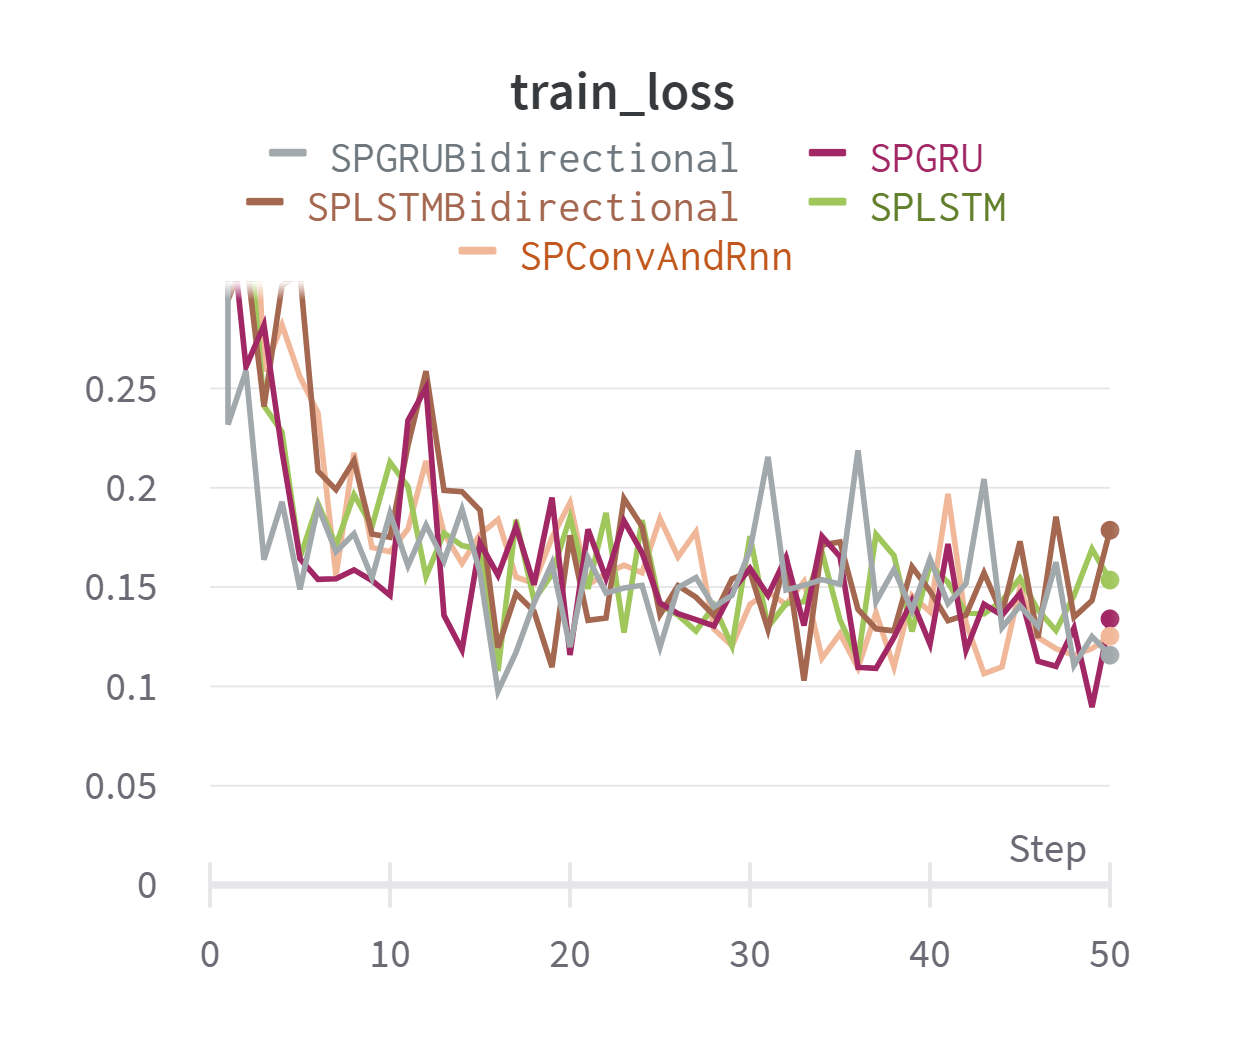

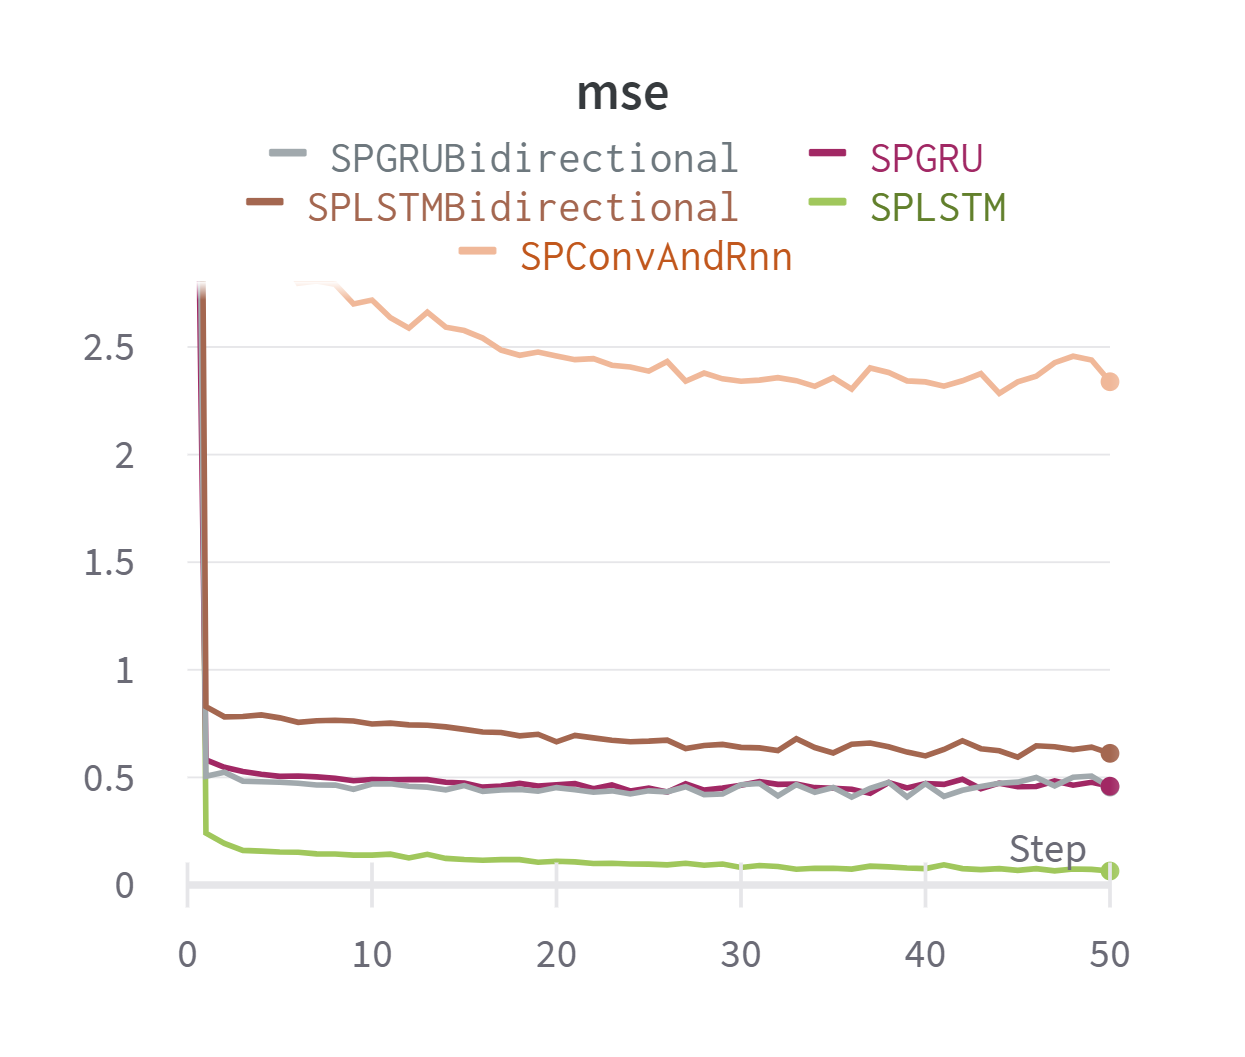

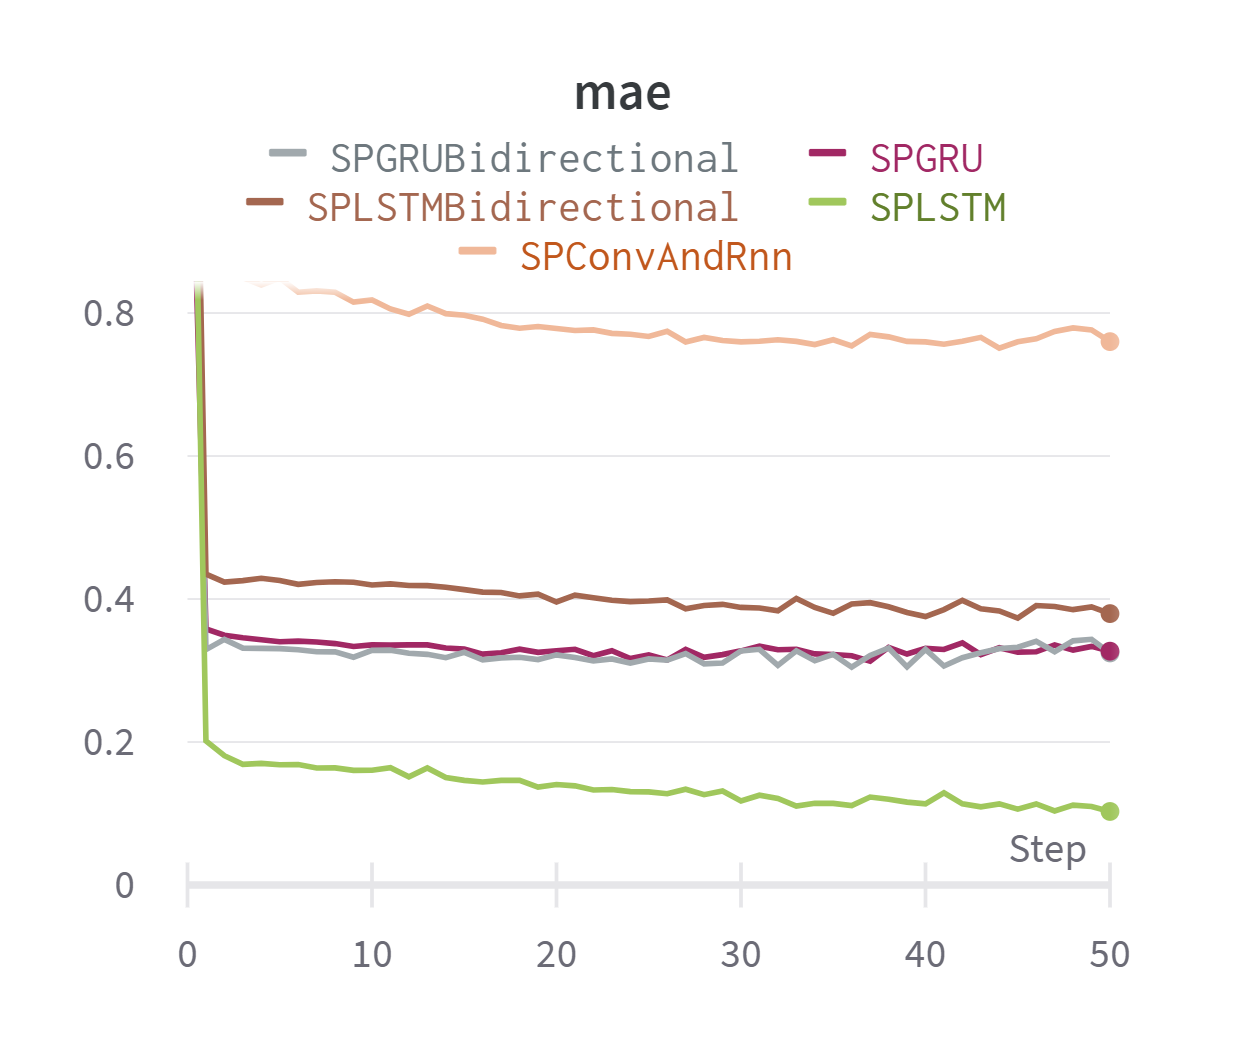

In [14]:
print_graphics('/content/drive/MyDrive/results/loss_rnn.png')
print_graphics('/content/drive/MyDrive/results/mse_rnn.png')
print_graphics('/content/drive/MyDrive/results/mae_rnn.png')

#**Часть 5:** ансамбль деревьев

В этой части я достала признаки с предпоследнего слоя с помощью метода модели children и передала их в RandomForestRegressor.

In [ ]:
class FeatureExctracter(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.seq = nn.Sequential(*list(model.children())[:-1])
        self.last_layer = model.final_predictor[0]
    
    def forward(self, batch):
        title_embeddings = self.seq[0](batch['Title']).permute(0, 2, 1)
        title_features = self.seq[1](title_embeddings).squeeze()

        description_embeddings = self.seq[0](batch['FullDescription']).permute(0, 2, 1)
        description_features = self.seq[2](description_embeddings).squeeze()

        categorical_features = self.seq[3](batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.last_layer(features)




In [ ]:
feature_extractor = FeatureExctracter(model)

In [ ]:
def get_features(data):
    out_features = torch.tensor([]).to(torch.device('cpu'))
    for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                        total=len(data) // BATCH_SIZE
            ):
            batch_pred = feature_extractor(batch)
            out_features = torch.cat((out_features, batch_pred.to(torch.device('cpu'))), 0)
    return out_features

In [ ]:
BATCH_SIZE = 128

In [ ]:
out_features_val = get_features(data_val).detach().numpy()

  0%|          | 0/191 [00:00<?, ?it/s]

In [ ]:
out_features_train = get_features(data_train).detach().numpy()

  0%|          | 0/55072 [00:00<?, ?it/s]

In [ ]:
out_features_train.shape

(220291, 8)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, 
                                 max_depth=50, 
                                 min_samples_leaf=4, 
                                 min_samples_split=10)
rf_model.fit(out_features_train, data_train[TARGET_COLUMN].to_numpy())
y_pred = rf_model.predict(out_features_val)

In [ ]:
y_pred

array([10.32546018, 10.26097654, 10.28537092, ..., 10.33153564,
       10.3402207 , 10.35334614])

In [ ]:
MSE = np.mean(np.square(y_pred - data_val[TARGET_COLUMN].to_numpy())) / len(data_val[TARGET_COLUMN])
MAE = np.mean(np.abs(y_pred - data_val[TARGET_COLUMN].to_numpy())) / len(data_val[TARGET_COLUMN])

In [ ]:
MSE

1.004118556980013e-05

In [ ]:
MAE

1.626291307185931e-05

### Выводы

Этот вариант показал один из лучших вариантов относително осальных значений судя по MSE и MAE.